# Histopathologic Cancer Detection

### Problem Overview:
In this 2018-2019 Kaggle competition, I was challenged with developing machine learning models to identify cancerous tissue within digital pathology scans. The images contain small, square patches extracted and deduplicated from the larger PatchCamelyon (PCam) benchmark. These patches are taken from whole slide images (WSIs) and represent a important area of focus in cancer diagnostics. The task was to create a binary classification model that could accurately classify between cancerous (positive) and non-cancerous (negative) tissue samples. There are very subtle visual differences between these two classes, which presents a significant challenge in machine learning and computer vision. Kaggle evaluates each submission using the Area Under the Receiver Operating Characteristic curve (AUC ROC). This metric evaluates the model's ability to segregate between the two classes across a range of classification thresholds. It is calculated by comparing the model's predicted probability of cancer for each image with the ground truth label. A higher AUC ROC score indicates better performance in identifying cancerous regions.

### Dataset:
The 7.76 GB dataset consists of 277,485 files, including two csv files and two folders named test and train that contain the .tif images. Files are named with an image id and the train_labels.csv file has the ground truth labels for the train images. The sample_submission.csv file provides an outline of how model outputs should be structured. The first column should have the image id and the second column with the label (0 or 1).There are 220,025 total train images and 57458 test images to use for predictions. 

### Dependencies

In [1]:
# !pip install seaborn

In [5]:
# standard
import os
import random
import datetime
from multiprocessing import Pool, cpu_count

# data handling and calculations
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# machine learning 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# deep learning and TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LayerNormalization, MultiHeadAttention, Flatten, Add, Reshape, Embedding
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import AUC
from tensorflow.keras.mixed_precision import LossScaleOptimizer

# image processing
import cv2
import glob

# optimization
import optuna
from optuna.integration import KerasPruningCallback

# progress bar utility
from tqdm import tqdm


In [ ]:
train_labels_path = pd.read_csv('/workspaces/histopathologic-cancer-detection/data/train_labels.csv')
train_path = '/workspaces/histopathologic-cancer-detection/data/train/'
test_path = '/workspaces/histopathologic-cancer-detection/data/test/'

### GPU Setup

In [24]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' # set log level to show all logs

print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA available:", tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
# list all GPUs
gpus = tf.config.list_physical_devices('GPU')

# check compute capability if GPU available
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {gpu.name}")
        print(f"Compute Capability: {details.get('compute_capability')}")
else:
    print("No GPU found.")

TensorFlow version: 2.13.0
Built with CUDA: True
CUDA available: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device: /physical_device:GPU:0
Compute Capability: (8, 6)


2025-02-19 21:50:02.868295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [25]:
# config GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Exploratory Data Analysis (EDA) and Preprocessing 
Here, I explore the data looking for any patterns that could give me clues on how to preprocess the images, clean the data, and setup my model architecture. I also preprocess my images.

### Label Counts and Image Size

Here, I look at the counts of labels to get a sense of class balance. The training set contains 130,908 non-cancerous images and 89,117 cancerous images. This means 59.5% of the images are labeled 0 and the remeaining 40.5% are labeled 1. Since the minority class is not less than 20% of the data, I believe we will not need to implement resampling techniques. There is slight class imbalance, but I do not believe it will impact model performance. 

Using CV2, I read the first image to find its shape and find that it is 96x96x3.

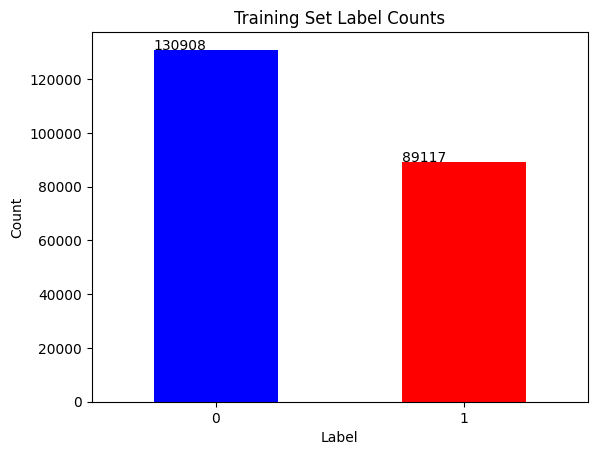

Image Height: 96
Image Width: 96
Number of Color Channels (BGR): 3


In [27]:
# look at the label stats
label_counts = train_labels_path['label'].value_counts()

# Create the bar plot
label_counts.plot(kind='bar', color=['blue', 'red']) 
plt.title("Training Set Label Counts")
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], rotation=0) 
for p in plt.gca().patches: 
    plt.annotate(str(p.get_height()), (p.get_x(), p.get_height()))
plt.show()

# look at image size: get a list of image file names in the training data
image_filenames = [img for img in os.listdir(train_path) if img.endswith('.tif')]

# read the first image
train_img_1 = cv2.imread(os.path.join(train_path, image_filenames[0]))

# get the height and width
height, width, num_color_channels = train_img_1.shape
print("Image Height:", height)
print("Image Width:", width)
print("Number of Color Channels (BGR):", num_color_channels)

### Corrupted Image Check

Now, I will check for corrupted images across the entire dataset. I loop through all images in training path and testing path and attempt to open each image with cv2.imread(). I log and count any images that fail to load then save the list of corrupted image IDs to inspect. Thankfully, there were no corrupted images!

In [7]:
def is_corrupted(img_path):
    """function to check if an image is corrupted"""
    img = cv2.imread(img_path)
    return img is None

# file paths for training and testing
train_image_paths = [os.path.join(train_path, f"{img_id}.tif") for img_id in train_labels_path['id']]
test_image_paths = [os.path.join(test_path, img_file) for img_file in os.listdir(test_path)]

def check_corrupted_images(image_paths):
    with Pool(cpu_count()) as pool:
        results = pool.map(is_corrupted, image_paths)
    return [image_paths[i] for i, corrupted in enumerate(results) if corrupted]

# check corrupted images in parallel
corrupted_train_images = check_corrupted_images(train_image_paths)
corrupted_test_images = check_corrupted_images(test_image_paths)

# summarize results
num_corrupted_train = len(corrupted_train_images)
num_corrupted_test = len(corrupted_test_images)
num_total_train = len(train_labels_path)
num_total_test = len(test_image_paths)

corrupted_image_data = {"Total Train Images": num_total_train,
                        "Corrupted Train Images": num_corrupted_train,
                        "Corrupted Train Image IDs": [os.path.basename(p).split(".")[0] for p in corrupted_train_images[:5]],
                        "Total Test Images": num_total_test,
                          "Corrupted Test Images": num_corrupted_test,
                          "Corrupted Test Image IDs": [os.path.basename(p) for p in corrupted_test_images[:5]]
                          }

corrupted_image_data

{'Total Train Images': 220025,
 'Corrupted Train Images': 0,
 'Corrupted Train Image IDs': [],
 'Total Test Images': 57458,
 'Corrupted Test Images': 0,
 'Corrupted Test Image IDs': []}

### Image Format Conversion and Positive/Negative Sample Visualization

The function read_image reads an image using cv2.imread and converts it to RGB format. OpenCV loads images in BGR format by default, not RGB. The conversion using: **cv2.cvtColor(img, cv2.COLOR_BGR2RGB)** is required because most libraries like Matplotlib expect RGB format for correct visualization. Blueboxes indicate negative samples with no tumor present (0), while red boxes indicate positive samples with tumor present (1). After visualizing the images, I instantly notice a lot of variation in staining. Some images contain nearly no staining, while others arevery dark purple. This clues me in to performing stain normalization so that my model does not pick up on the human error introduced from staining, but rather the actual cell morphology when looking for cancerous cells. 

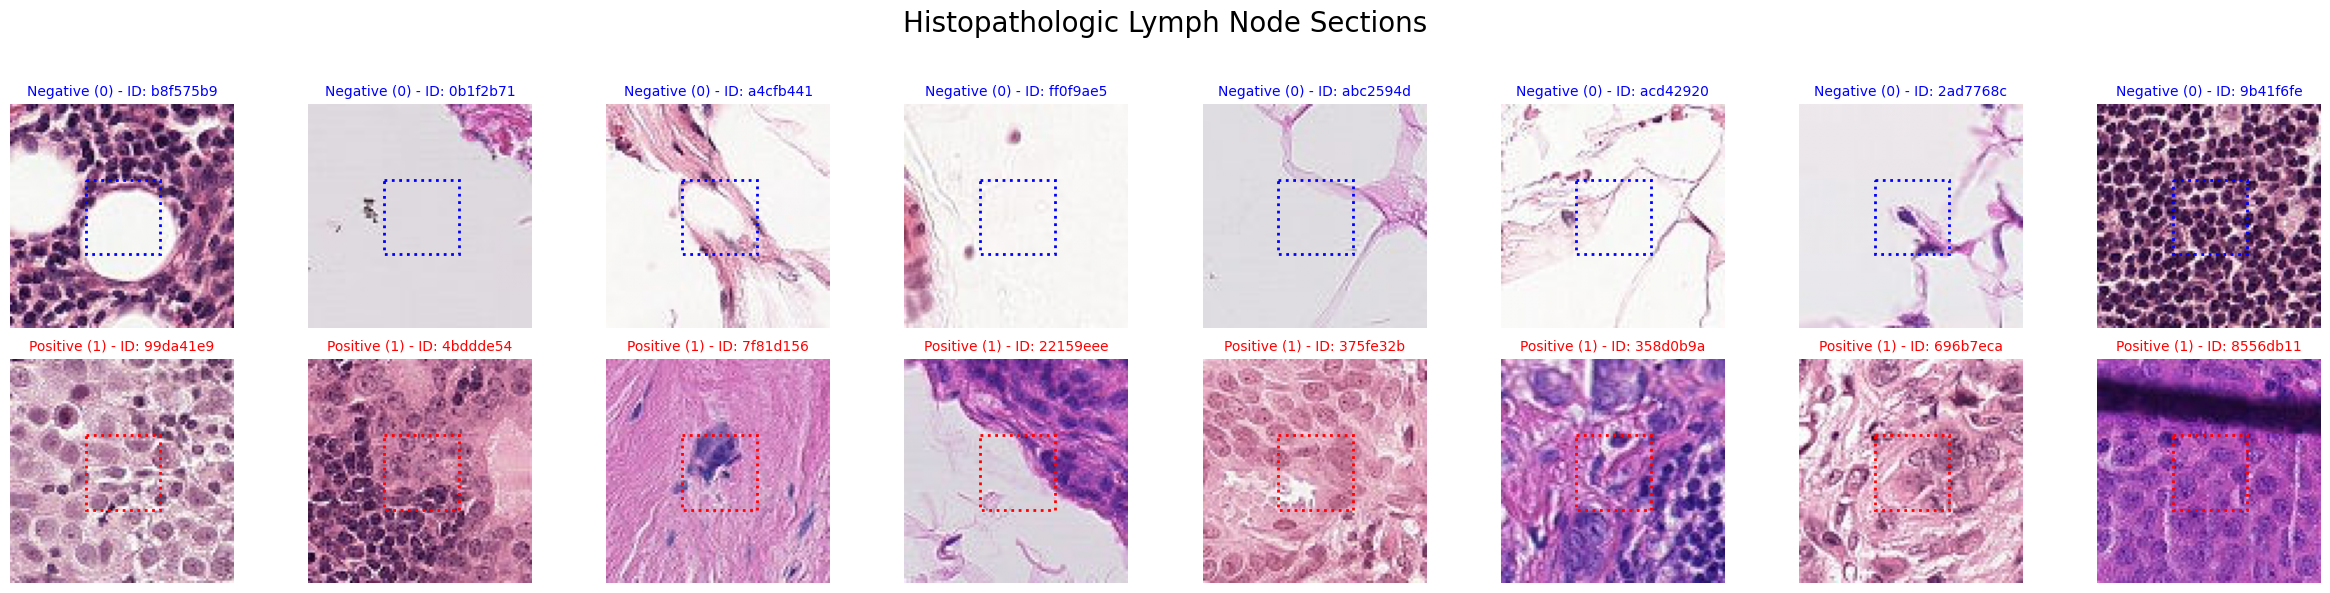

In [28]:
def read_image(path):
    img = cv2.imread(path)
    if img is None:
        print(f"Unable to load image {path}")
        return np.zeros((96,96,3), dtype=np.uint8) # return a black image if error
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0 # normalize for better visualization

# sample images 
negative_samples = train_labels_path[train_labels_path['label'] == 0].sample(n=8, random_state=100)
positive_samples = train_labels_path[train_labels_path['label'] == 1].sample(n=8, random_state=100)

fig, ax = plt.subplots(2, 8, figsize=(24, 6)) 
fig.suptitle('Histopathologic Lymph Node Sections', fontsize=20)

# reduce spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.3) # reduce white space

# negative samples
for i, img_id in enumerate(negative_samples['id']):
    path = os.path.join(train_path, img_id + '.tif')
    ax[0, i].imshow(read_image(path))
    ax[0, i].set_title(f"Negative (0) - ID: {img_id[:8]}", fontsize=10, color='blue')
    ax[0, i].axis('off')

    # add 32x32 center region box
    box = patches.Rectangle((32, 32), 32, 32, linewidth=2, edgecolor='b', facecolor='none', linestyle=':')
    ax[0, i].add_patch(box)

# positive samples
for i, img_id in enumerate(positive_samples['id']):
    path = os.path.join(train_path, img_id + '.tif')
    ax[1, i].imshow(read_image(path))
    ax[1, i].set_title(f"Positive (1) - ID: {img_id[:8]}", fontsize=10, color='red')
    ax[1, i].axis('off')

    # add 32x32 center region box
    box = patches.Rectangle((32, 32), 32, 32, linewidth=2, edgecolor='r', facecolor='none', linestyle=':')
    ax[1, i].add_patch(box)

# optimize layout
plt.tight_layout(rect=[0, 0, 1, 0.95]) # adjust so title doesn't overlap
plt.show()

I noticed that there is a lot of variation in the staining of the slides. After, my first pass of my model, I also saw that many misclassified images, particularly, false negatives, were darker in stianing overall. So I decided to perform stain normalization during my preprcoessing.  

### Stain Normalization
Here, I find a well stained image to use as a reference for my stain normalization. I randomly sample 10,000 images and computer their median color. Then I find the image within those 10,000 that most closely matches this median color and save its path to best_refernce_img.

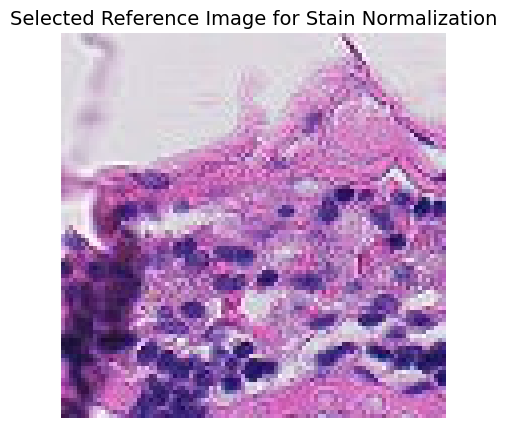

Best Reference Image Path: /workspaces/histopathologic-cancer-detection/data/train/6b31d13cddba5be487c841b223a88fdb2d5c060a.tif


In [9]:
image_paths = glob.glob(os.path.join(train_path, "*.tif"))

# randomly select 10000 images (w/o reading them)
num_samples = 10000  
selected_paths = np.random.choice(image_paths, num_samples, replace=False)

# use read_image() on selected images
color_means = [np.mean(read_image(path), axis=(0,1)) for path in selected_paths]  # Compute mean RGB

# calc median color
color_means = np.array(color_means)
median_color = np.median(color_means, axis=0)

# find the best reference image
closest_idx = np.argmin(np.linalg.norm(color_means - median_color, axis=1))
best_reference_image_path = selected_paths[closest_idx]

# read and show best stained image
best_reference_img = read_image(best_reference_image_path)

plt.figure(figsize=(5,5))
plt.imshow(best_reference_img)
plt.title("Selected Reference Image for Stain Normalization", fontsize=14)
plt.axis("off")
plt.show()
print("Best Reference Image Path:", best_reference_image_path)

Here, I chose to use Macenko Normalization because it performs well on slides dyed with Hematoxylin and Eosin (H&E). Since images are coming from different sources we need accurate color representation. I actually added this in to my last run of the model after seeing that many of the false negative images contain large edge patterns and variations in staining and texture. Since this seemed to be contributing to misclassifcation, I thought stain normalization would reduce variance between slides. 

My function is modified from the StainTools library (https://github.com/Peter554/StainTools/tree/master) My function uses a single pipeline approach that uses an OD-based background threshold and SVD to calculate the principal stains. SstainTools uses on a Lab based luminosity mask and eigen decomposition to get the main stain axes. I modified the original method to simplify background removal (through OD threshold) and to fail gracefully by returning the original image if too few tissue pixels remain. This helps avoid  errors on slides with very little staining.

In [ ]:
# load ref image
reference_image_path = best_reference_image_path
reference_image = cv2.imread(reference_image_path)
reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)

def macenko_normalization(img, ref_img=reference_image, Io=240, alpha=1, beta=0.1):
    """
    Perform Macenko stain normalization using a reference image
    img: Input RGB image
    ref_img: Reference RGB image for stain normalization
    Io: Reference intensity 
    alpha: OD percentile for normalization
    beta: OD threshold for background removal
    return: Stain-normalized image with corrected colors
    """
    h, w, c = img.shape # original dims

    # change the input and reference to optical density (OD) space
    img = img.astype(np.float32) + 1  
    ref_img = ref_img.astype(np.float32) + 1  
    OD = -np.log(img / Io)
    OD_ref = -np.log(ref_img / Io)

    # remove background pixels
    OD = OD.reshape((-1, 3))
    OD_ref = OD_ref.reshape((-1, 3))
    OD_filtered = OD[np.all(OD > beta, axis=1)]
    OD_ref_filtered = OD_ref[np.all(OD_ref > beta, axis=1)]

    # if filtering removes too much, return original image
    if OD_filtered.shape[0] < 20 or OD_ref_filtered.shape[0] < 20:
        return img.astype(np.float32)

    # calc stain matrices for input and reference
    _, _, V = np.linalg.svd(OD_filtered, full_matrices=False)
    stain_matrix = V[:2, :]
    
    _, _, V_ref = np.linalg.svd(OD_ref_filtered, full_matrices=False)
    stain_matrix_ref = V_ref[:2, :]

    # calc stain concentrations
    concentration = np.linalg.lstsq(stain_matrix.T, OD.T, rcond=None)[0]
    concentration_ref = np.linalg.lstsq(stain_matrix_ref.T, OD_ref.T, rcond=None)[0]

    # normalize stain concentrations based on reference img
    max_concentration = np.percentile(concentration_ref, alpha, axis=1, keepdims=True)
    concentration *= (max_concentration / np.percentile(concentration, alpha, axis=1, keepdims=True))

    # reconstruct img from normalized stain concentrations
    normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
    normalized_img = np.clip(normalized_img, 0, 255).astype(np.float32)

    # check correct shape
    try:
        normalized_img = normalized_img.reshape((h, w, c))  
    except ValueError:
        print(f"Failed reshaping, returning original image. Expected ({h},{w},{c}), got {normalized_img.shape}")
        return img.astype(np.float32)

    return (normalized_img).astype(np.uint8)

### Image Preprocessing and Augmentation

To improve model robustness and focus on relevant tissue areas, I applied adapted augmentations from Joni Juvonen's public Kaggle Notebook (https://www.kaggle.com/code/qitvision/a-complete-ml-pipeline-fast-ai). Similarly, my model performed better when I did not crop my image as much. I orginally ran my model with crop size set to 32x32, since that is where the tumors are present if they are cancerous. However, my model did not perform nearly as well as when I performed minimal cropping. I also expanded on Joni's work to perform all of the following augmentations:

- Cropping: Reduced image size from 96x96 to 90x90 pixels to remove edge artifacts and allow small random shifts (+/- 3 pixels). 
- Rotation & Shifting: Random rotation (+/- 3°) and optional 90° turns to add variation. Random shifts gives the model different perspectives
- Flipping & Color Adjustments: Horizontal/vertical flips, hue shifts, and brightness/contrast adjustments to enhance generalization.
- Elastic Deformation: Simulates realistic tissue distortions using a smoothing factor (σ = 0.05 * crop_size)
- Gaussian Noise: Introduces slight noise (σ = 5) to improve model robustness

These augmentations help the model generalize better to unseen histology images.


In [30]:
# constants
original_size = 96 # DO NOT CHANGE
crop_size = 90 # final crop size

# augmentation parameters
random_rotation = 3 # degrees
random_shift = 3  # pixel shift for cropping
random_brightness = 0.1 # brightness adjustment (scaled to 0-1, converted to 0-255)
random_contrast = 0.1 # contrast adjustment
random_90_degree_turn = True # random 90 degree rotation

# elastic deformation 
alpha = 2.0 # scaling factor for deformation
sigma = 0.05 * crop_size # smoothing factor

# noise
noise_stddev = 5 # stdev of Gaussian noise

def read_cropped_image(path, augment=True):
    """Reads an image, applies augmentations, and returns normalized cropped image"""
    # read image (OpenCV loads BGR format)
    img = cv2.imread(path)

    # handle missing or corrupted images
    if img is None:
        print(f"Warning: Failed to load image {path}. Returning blank image.")
        return np.zeros((crop_size, crop_size, 3), dtype=np.float32)

    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # if no augmentations, crop and return normalized image
    if not augment:
        start_crop = (original_size - crop_size) // 2 # center crop
        img = img[start_crop:start_crop+crop_size, start_crop:start_crop+crop_size] / 255.0
        return img.astype(np.float32)

    # image augmentations
    img = macenko_normalization(img, ref_img=reference_image)
    
    # random rotation
    angle = random.randint(-random_rotation, random_rotation)
    if random_90_degree_turn:
        angle += random.choice([0, 90, -90, 180])
    transformation_matrix = cv2.getRotationMatrix2D((original_size // 2, original_size // 2), angle, 1)
    img = cv2.warpAffine(img, transformation_matrix, (original_size, original_size), borderMode=cv2.BORDER_REFLECT_101) 

    # random shift
    x_shift = random.randint(-random_shift, random_shift)
    y_shift = random.randint(-random_shift, random_shift)
    start_crop = (original_size - crop_size) // 2
    img = img[start_crop + y_shift:start_crop + y_shift + crop_size, start_crop + x_shift:start_crop + x_shift + crop_size]

    # random Flip
    if random.random() < 0.5:
        img = cv2.flip(img, 1) # horizontal 
    if random.random() < 0.2:
        img = cv2.flip(img, 0) # vertical 

    # hue shift 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hue_shift = random.randint(-5, 5)
    hsv[:, :, 0] = np.clip(hsv[:, :, 0] + hue_shift, 0, 179)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # elastic deformation 
    dx = cv2.GaussianBlur((np.random.rand(*img.shape[:2]) * 2 - 1), (17, 17), sigma) * alpha
    dy = cv2.GaussianBlur((np.random.rand(*img.shape[:2]) * 2 - 1), (17, 17), sigma) * alpha
    x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)
    img = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    # random brightness/contrast
    brightness = random.uniform(-random_brightness, random_brightness) * 255 # scale brightness 
    contrast = random.uniform(1.0 - random_contrast, 1.0 + random_contrast)
    img = np.clip(contrast * img + brightness, 0, 255).astype(np.float32)

    # Gaussian noise
    noise_stddev_scaled = max(noise_stddev, 0.05 * np.mean(img))
    noise = np.random.normal(0, noise_stddev_scaled, img.shape).astype(np.float32)
    img = np.clip(img + noise, 0, 255).astype(np.float32)

    # normalize to [0,1]
    img /= 255.0

    return img

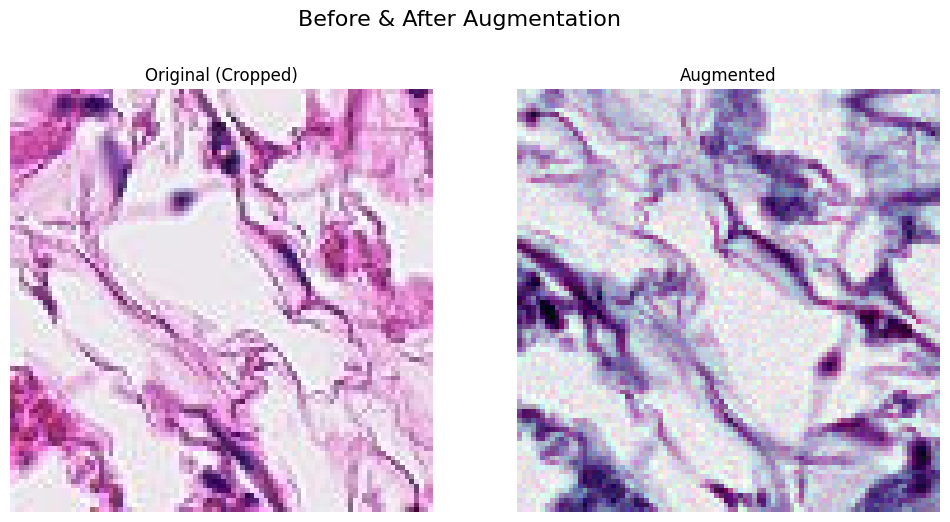

In [31]:
# select random image ID
sample_id = train_labels_path.sample(1, random_state=100)['id'].values[0]
sample_path = os.path.join(train_path, sample_id + '.tif')

# before and after augmentation
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Before & After Augmentation', fontsize=16)

# og image
ax[0].imshow(read_cropped_image(sample_path, augment=False))
ax[0].set_title('Original (Cropped)')
ax[0].axis('off')

# augmented image
ax[1].imshow(read_cropped_image(sample_path, augment=True))
ax[1].set_title('Augmented')
ax[1].axis('off')
plt.show()

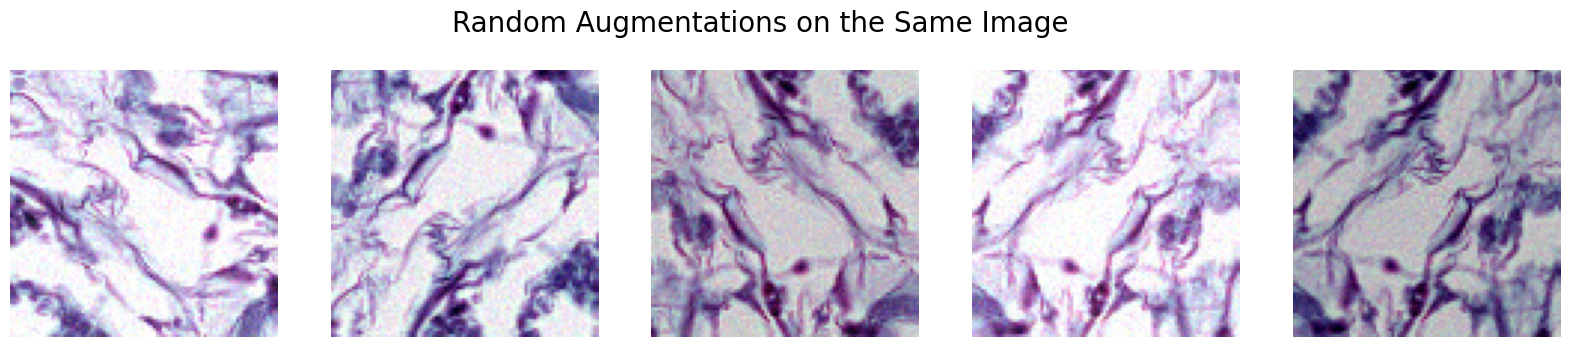

In [32]:
# multiple augmentations on same image 
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Random Augmentations on the Same Image', fontsize=20)

for i in range(5):
    ax[i].imshow(read_cropped_image(sample_path, augment=True))
    ax[i].axis('off')

plt.show()

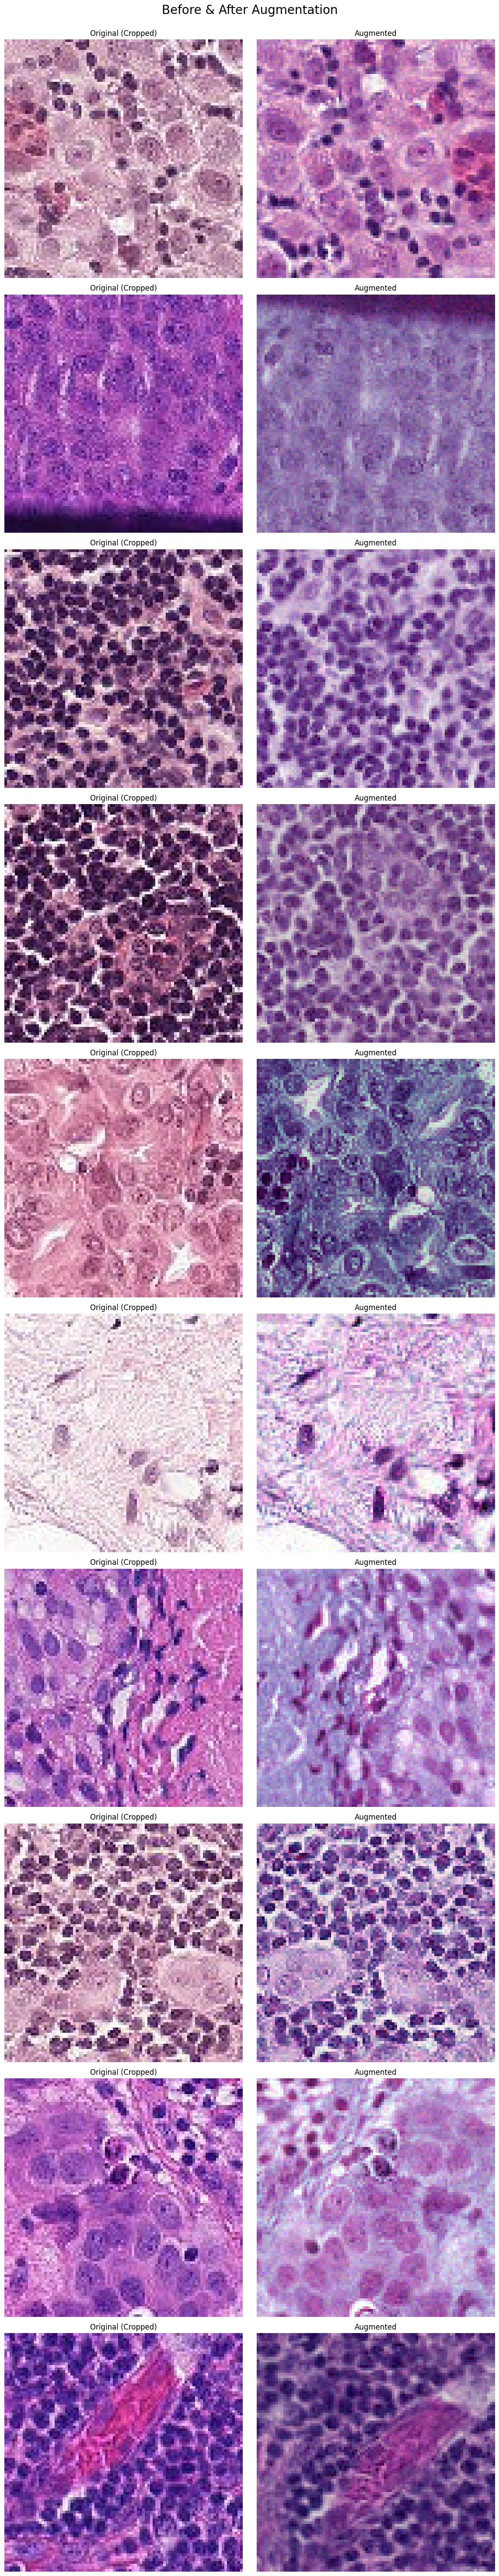

In [14]:
# random states for different images
random_states = np.random.randint(0, 100000, size=10)

fig, axes = plt.subplots(10, 2, figsize=(12, 60))
fig.suptitle('Before & After Augmentation', fontsize=20)

# loop through 10 random states to get images
for i, rand_state in enumerate(random_states):
    # get random img ID
    sample_id = train_labels_path.sample(1, random_state=rand_state)['id'].values[0]
    sample_path = os.path.join(train_path, sample_id + '.tif')

    # load og and augmented 
    original_img = read_cropped_image(sample_path, augment=False)
    augmented_img = read_cropped_image(sample_path, augment=True)

    # plot og img
    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title('Original (Cropped)')
    axes[i, 0].axis('off')

    # plot augmented img
    axes[i, 1].imshow(augmented_img)
    axes[i, 1].set_title('Augmented')
    axes[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, .98]) # fit title
plt.show()

### Statistics

Image statistics like channel mean, standard deviation, and brightness help me make normalization choices. This dataset has a higher mean than ImageNet, but since I’m fine-tuning EfficientNet, I used ImageNet’s mean & std. The standard deviation was similar to ImageNet, indicating no major contrast issues.  

Stats also help detect problematic images like extremely dark image (possibly corrupted) and overly bright ones (potential overexposure). I may remove them if they impact training. When I first ran my stats code I had detected one extremely dark image and 12 overly exposed image. After applying stain normalization, no images were extremely dark or bright. 


In [ ]:
# thresholds for extreme images
dark_threshold = 10 / 255 # if max pixel intensity < 10, image is too dark
bright_threshold = 245 / 255 # if min pixel intensity > 245, image is too bright

def process_image(img_id):
    """Function to process a single image"""
    img_path = os.path.join(train_path, img_id + ".tif")
    img = read_cropped_image(img_path, augment=True) # no augmentations

    # reshape image to (N, 3) for channel stats
    img_reshaped = img.reshape(-1, 3)

    # check for extremely dark/bright images
    if img_reshaped.max() < dark_threshold:
        return {"status": "too_dark", "img_id": img_id}
    if img_reshaped.min() > bright_threshold:
        return {"status": "too_bright", "img_id": img_id}

    # mean and squared mean for stats
    return {"status": "normal", "mean": img_reshaped.mean(axis=0), "squared_mean": (img_reshaped ** 2).mean(axis=0)}

# get list of image IDs
image_ids = train_labels_path['id'].tolist()

# use multiprocessing to process images faster
with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(process_image, image_ids), total=len(image_ids), desc="Computing statistics"))

# initialize
x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0
too_dark_idx = []
too_bright_idx = []

# agg results
for result in results:
    if result["status"] == "too_dark":
        too_dark_idx.append(result["img_id"])
    elif result["status"] == "too_bright":
        too_bright_idx.append(result["img_id"])
    else:
        x_tot += result["mean"]
        x2_tot += result["squared_mean"]
        counted_ones += 1

# calc final mean & std values
channel_mean = x_tot / counted_ones
channel_std = np.sqrt(x2_tot / counted_ones - channel_mean ** 2)

# results
image_statistics = {"Channel Mean": channel_mean.tolist(),
                    "Channel Std": channel_std.tolist(),
                    "Total Images Processed": counted_ones,
                    "Extremely Dark Images": len(too_dark_idx),
                    "Extremely Bright Images": len(too_bright_idx),
                    "First 5 Dark Image IDs": too_dark_idx[:5],
                    "First 5 Bright Image IDs": too_bright_idx[:5]}
image_statistics

### ImageNet Normalization and TensorFlow Pipeline

EfficientNetV2 expects zero-centered normalization: **img = (img - imagenet_mean) / imagenet_std**, aligns pixel values with ImageNet stats for better performance. The initial **/ 255.0** scaling makes values interpretable, while ImageNet normalization provides model compatibility.  

I use ImageNet mean ([0.485, 0.456, 0.406]) and std ([0.229, 0.224, 0.225]) to match the pretrained EfficientNetV2 and ViT-Hybrid models, maintaining consistency for effective transfer learning.  

In [33]:
# imageNet mean and std for normalization
imagenet_mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
imagenet_std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def normalize_image_for_efficientnet(img):
    """Normalize image using ImageNet statistics for EfficientNetV2"""
    return ((img - imagenet_mean) / imagenet_std).astype(np.float32) # float32 output

def preprocess_image(img_path, dataset_type='train'):
    """Load, crop, scale, and normalize image for TensorFlow dataset pipeline"""
    if isinstance(img_path, tf.Tensor):  
        img_path = img_path.numpy().decode("utf-8") # change tensor to string
    
    # handle augmentation based on dataset type
    if dataset_type == 'train':
        img = read_cropped_image(img_path, augment=True) # augment for training
    else:
        img = read_cropped_image(img_path, augment=False) # no augmentation for val/test
    
    return tf.cast(normalize_image_for_efficientnet(img), tf.float16) # normalize for EfficientNet

def build_tf_dataset(image_paths, labels, batch_size=128, shuffle=True, model_name='efficientnet', dataset_type='train'):
    """Creates a TensorFlow dataset with preprocessing and augmentation"""
    def load_image(img_path, label):
        img = tf.py_function(preprocess_image, [img_path], Tout=tf.float16) # float16 dtype
        img.set_shape([crop_size, crop_size, 3]) # fixed shape
        label = tf.cast(label, tf.float16) # match dtype for mixed precision
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000) # chose 10,000 bc good mix between variation w/o too much computation time 

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


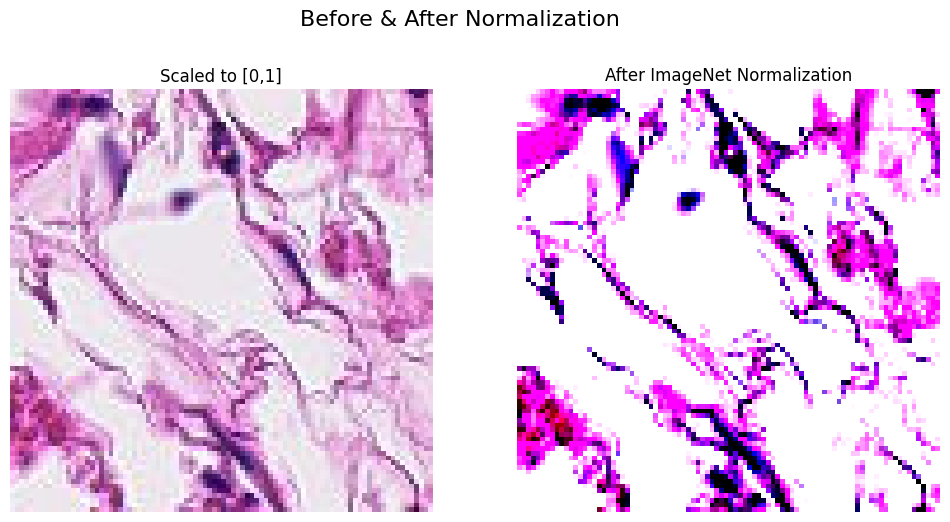

In [34]:
# select random sample image
sample_id = train_labels_path.sample(1, random_state=100)['id'].values[0]
sample_path = os.path.join(train_path, sample_id + '.tif')

# test preprocessing
original_image = read_cropped_image(sample_path, augment=False) # first normalization
normalized_image = normalize_image_for_efficientnet(original_image) # imageNet normalization

# plot before & after normalization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Before & After Normalization', fontsize=16)

ax[0].imshow(original_image)
ax[0].set_title('Scaled to [0,1]')
ax[0].axis('off')

ax[1].imshow(normalized_image)
ax[1].set_title('After ImageNet Normalization')
ax[1].axis('off')
plt.show()

### Removing the Bright and Dark Images before Training

In [ ]:
# remove dark and bright images from train_labels
filtered_train_labels = train_labels_path[~train_labels_path['id'].isin(too_dark_idx + too_bright_idx)]

# do NOT filter out dark and bright images
#filtered_train_labels = train_labels_path.copy() # keep all images

# print new dataset size
print(f"Original dataset size: {len(train_labels_path)}")
print(f"Filtered dataset size: {len(filtered_train_labels)}")

Original dataset size: 220025
Filtered dataset size: 220025


### Train Test Split (80/20) with Stratification

In [37]:
# stratified split to maintain class balance
train_ids, val_ids = train_test_split(filtered_train_labels['id'], test_size=0.2, stratify=filtered_train_labels['label'],  random_state=100)

# create new train/val datasets
train_df = filtered_train_labels[filtered_train_labels['id'].isin(train_ids)]
val_df = filtered_train_labels[filtered_train_labels['id'].isin(val_ids)]

# print split sizes
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 176020
Validation set size: 44005


### Checking Training and Validation Set Class Balance
No major class imbalances were seen when plotting the training set and validation set label counts. 

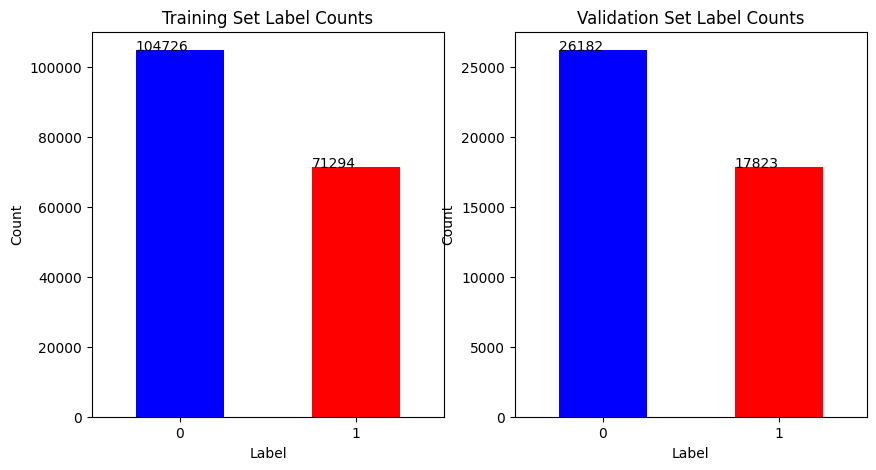

In [38]:
# get the counts
train_counts = train_df['label'].value_counts()
val_counts = val_df['label'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

train_counts.plot(kind='bar', ax=axes[0], color=['blue', 'red'])
axes[0].set_title('Training Set Label Counts')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['0', '1'], rotation=0) 
for p in axes[0].patches:
    axes[0].annotate(str(p.get_height()), (p.get_x(), p.get_height()))


val_counts.plot(kind='bar', ax=axes[1], color=['blue', 'red']) 
axes[1].set_title('Validation Set Label Counts')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['0', '1'], rotation=0) 
for p in axes[1].patches: 
    axes[1].annotate(str(p.get_height()), (p.get_x(), p.get_height()))

plt.show()

# Model Development Strategy and Training  

EfficientNetV2s is a CNN, so it excels at local feature extraction (textures, edges), while Vision Transformer models capture global dependencies. Given the dataset size (176k train, 44k val) and the fact that histology slides have fine grained patterns in cell structures and broader contextual information like tissue organization I decided to use EfficientNetV2S as my baseline model and vision transformer hybrid model.
EfficientNetV2S is optimized for CNN-based feature extraction, using transfer learning with a lightweight classification head (128 → 1).
My ViT-Hybrid model will then use EfficientNetV2S as a backbone while including transformer-based multi-head attention layers, allowing it to capture both fine and high-level features.

### Training EfficientNetV2S with One-Cycle Policy

One-Cycle Learning Rate (LR) Policy is a way to dynamically adjust the learning rate instead of keeping it constant, leading to faster convergence and reduced overfitting. This approach involves:  

Warm-up phase: LR gradually increases to a peak value.  
Decay phase: LR smoothly decreases for better convergence.  
Momentum scheduling: Inversely adjusted to stabilize training.  

*Sources:* 

*[Leslie N. Smith, 2018](https://arxiv.org/pdf/1803.09820)*  
*[Leslie N. Smith, 2017](https://arxiv.org/pdf/1506.01186)*

#### EfficientNetV2S Training Pipeline
1. Learning Rate & Hyperparameter Optimization

 - Load a pretrained EfficientNetV2S model (ImageNet weights)
 - Run an LR range test with all layers trainable to determine the optimal learning rate
 - Use Optuna to tune weight decay (prevents overfitting) and dropout rate (reduces over-reliance on specific features)
 - Since hyperparameter tuning is computationally expensive, I used only 25% of the training and validation data for faster optimization

2. Feature Extraction (Transfer Learning)

 - Reload the pretrained EfficientNetV2S model with optimized hyperparameters
 - Freeze all convolutional layers to retain ImageNet-learned features
 - Train only the classification head (128 → 1 dense layers) to adapt the model to the new dataset

3. Fine-Tuning

 - Unfreeze all layers and train the full model
 - Use mixed precision training for efficiency and faster convergence
 - Apply One-Cycle Policy to dynamically adjust learning rate and momentum for stable training

Final Model Training Setup:

Batch Size: 128

Base LR: 0.0015 → Peak LR: 0.0045

Momentum Range: 0.9 → 0.95

Step Size: 2 × iterations per epoch (for full One-Cycle schedule)

### Learning Rate Range Test

In [21]:
# enable mixed precision training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# load EfficientNetV2-S model (w/o top layer)
base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(crop_size, crop_size, 3))
# add classification head and perform feature extraction
x = GlobalAveragePooling2D(dtype="float16")(base_model.output)
# FC layers w dropout
x = Dense(128, activation='gelu', dtype="float16")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid', dtype="float32")(x) # for more numerical stability, I cast final output layer to float32

# calc iterations per epoch
batch_size = 128
iterations_per_epoch = len(train_df) // batch_size  

# choose step size for lr range test
stepsize = 2 * iterations_per_epoch # recommended from the paper (shorter test)
# stepsize = 10 * iterations_per_epoch # Uncomment for a longer test
print(f"Computed stepsize for LR range test: {stepsize}")

# all layers trainable for full test
for layer in base_model.layers:
    layer.trainable = True  

# lr range test callback
class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-6, max_lr=0.5, steps=stepsize, validation_data=None):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.history = []
        self.best_loss = float('inf')
        self.validation_data = validation_data

    def on_batch_begin(self, batch, logs=None):
        if batch == 0:
            self.lr = self.min_lr
        else:
            self.lr = self.lr * (self.max_lr / self.min_lr) ** (1 / self.steps)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_batch_end(self, batch, logs=None):
        """Record loss and stop if loss explodes"""
        train_loss = logs["loss"]
        val_loss, val_acc = None, None
        # calc val loss/accuracy if val dataset provided
        if self.validation_data and batch % 10 == 0: # only eval every 10 batches (for efficiency)
            val_loss, val_acc = self.model.evaluate(self.validation_data, verbose=0)[:2]

        self.history.append((self.lr, train_loss, val_loss, val_acc))

        # stop training if loss explodes
        if train_loss < self.best_loss:
            self.best_loss = train_loss
        if train_loss > self.best_loss * 4:
            self.model.stop_training = True
            
    def on_epoch_end(self, epoch, logs=None):
        """Makes sure validation data is logged at the end of the epoch"""
        logs = logs or {}
        logs["lr"] = tf.keras.backend.get_value(self.model.optimizer.lr)

# build TensorFlow dataset
train_ds = build_tf_dataset([os.path.join(train_path, img_id + ".tif") for img_id in train_df['id']], train_df['label'].values, model_name='efficientnet', dataset_type='train').repeat()
val_ds = build_tf_dataset([os.path.join(train_path, img_id + ".tif") for img_id in val_df['id']], val_df['label'].values, shuffle=False, model_name='efficientnet', dataset_type='val')
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

# use SGD 
optimizer = LossScaleOptimizer(SGD(learning_rate=1e-6, momentum=0.95))
# build model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])
    
# run lr range test
lr_finder = LRFinder(min_lr=1e-6, max_lr=0.1, steps=stepsize, validation_data=val_ds)
history = model.fit(train_ds, validation_data=val_ds, epochs=1, steps_per_epoch=stepsize, callbacks=[lr_finder])

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2025-02-18 22:31:36.957935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-18 22:31:36.978014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-18 22:31:36.978186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-18 22:31:36.978305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-18 22:31:37.099090: I tensorflow/compile

Computed stepsize for LR range test: 2750


2025-02-18 22:32:06.346998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2211 of 10000
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in exp
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in multiply
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
2025-02-18 22:32:16.354821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4494 of 10000
2025-02-18 22:32:26.342565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6713 of 10000
2025-02-18 22:32:36.341199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8928 of 10000
2025-02-18 22:32:41.086551: I tensorflow/core/kernels/data/shuffle_datase

1376/2750 [==============>...............] - ETA: 27:20 - loss: 0.5778 - accuracy: 0.7221 - auc: 0.7781  

2025-02-18 23:03:39.596728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2292 of 10000
2025-02-18 23:03:49.622931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4521 of 10000
2025-02-18 23:03:59.596148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6816 of 10000
2025-02-18 23:04:09.601089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8998 of 10000
2025-02-18 23:04:14.029869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


2750/2750 [==============================] - 2845s 937ms/step - loss: 1.5206 - accuracy: 0.5960 - auc: 0.5649 - val_loss: 1.5023 - val_accuracy: 0.5962 - val_auc: 0.5568 - lr: 0.0066


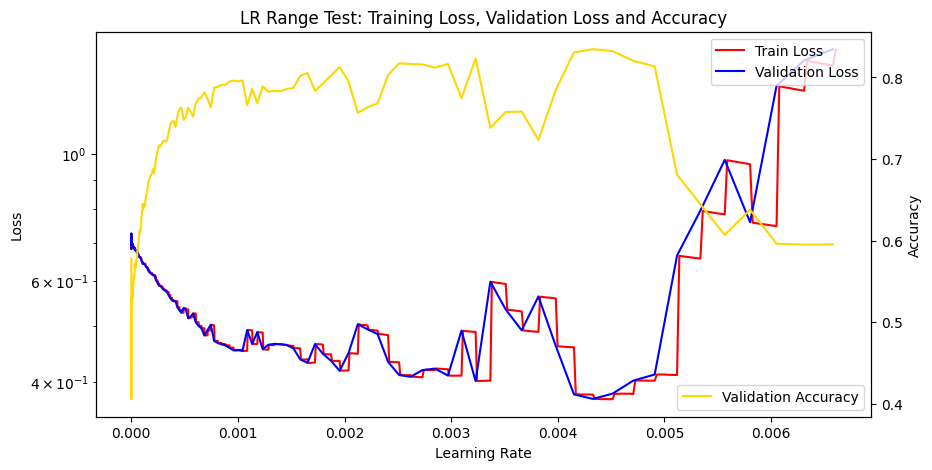

In [22]:
# store lr range test results
learning_rates, train_losses, val_losses, val_accs = zip(*lr_finder.history)

# convert lists to arrays for easy filtering
learning_rates = np.array(learning_rates)
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
val_accs = np.array(val_accs)
    
# remove None/NaN values from val metrics
valid_indices = np.where(val_losses != None)[0] 
valid_lrs = learning_rates[valid_indices]
valid_val_losses = val_losses[valid_indices]
valid_val_accs = val_accs[valid_indices]

fig, ax1 = plt.subplots(figsize=(10,5))
# plot train loss
ax1.plot(learning_rates, train_losses, label="Train Loss", color="red")
# plot val loss for valid points only
ax1.plot(valid_lrs, valid_val_losses, label="Validation Loss", color="blue")
    
ax1.set_xscale("linear") # keep x-axis linear 
ax1.set_yscale("log") # log for loss
ax1.set_xlabel("Learning Rate")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")
    
# second y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(valid_lrs, valid_val_accs, label="Validation Accuracy", color="gold")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")
plt.title(f"LR Range Test: Training Loss, Validation Loss and Accuracy")
plt.show()

### LR Range Test Insights:
Training & Validation Losses (Red & Blue Lines)
 - Loss decreases steadily until ~0.0020
 - After ~0.0050, the loss is too high as it starts fluctuating and becomes unstable, as seen in the sharp increase

Validation Accuracy (Yellow Line)
 - Initially increases and stabilizes up to ~0.0015
 - Becomes unstable at > ~0.005

Best One-Cycle LR Values:
 - Base Learning Rate (base_lr) → 0.0010 - 0.0015 (safe low region)
 - Max Learning Rate (max_lr) → 0.0040 - 0.0045 (before instability kicks in)

### Tuning Weigth Decay and Dropout
I chose to use 0.003 for my fixed LR here because its between the base_lr and max_lr. Too low of a fixed LR will not give me any meaningful results, while too high of a LR could introduce instability. Therefore, 0.003 will be stable and allow WD and dropout impact to be visible without over regularization. 

In [23]:
# create dataset once before Optuna
train_sample = train_df.sample(frac=0.25, random_state=100).reset_index(drop=True)
train_ds_subset = build_tf_dataset([os.path.join(train_path, img_id + ".tif") for img_id in train_sample['id']], train_sample['label'].values, model_name='efficientnet', dataset_type='train').prefetch(tf.data.AUTOTUNE) 

val_sample = val_df.sample(frac=0.25, random_state=100).reset_index(drop=True)
val_ds_subset = build_tf_dataset([os.path.join(train_path, img_id + ".tif") for img_id in val_sample['id']], val_sample['label'].values, shuffle=False, model_name='efficientnet', dataset_type='val').cache().prefetch(tf.data.AUTOTUNE)  

def objective(trial, train_ds, val_ds):
    wd = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.05)

    base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(crop_size, crop_size, 3))
    
    x = GlobalAveragePooling2D(dtype="float16")(base_model.output)
    x = Dense(128, activation='gelu', dtype="float16")(x)
    x = Dropout(dropout)(x)
    x = Dense(1, activation='sigmoid', dtype="float32")(x)

    optimizer = LossScaleOptimizer(SGD(learning_rate=0.003, momentum=0.95, weight_decay=wd))
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

    history = model.fit(train_ds, validation_data=val_ds, epochs=1, steps_per_epoch=len(train_sample) // 128, verbose=0)

    return history.history["val_loss"][-1]

# run Optuna w prebuilt dataset
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train_ds_subset, val_ds_subset), n_trials=30)

best_params = study.best_params
print(f"Best weight decay: {best_params['weight_decay']}")
print(f"Best dropout: {best_params['dropout']}")

[I 2025-02-18 23:30:38,583] A new study created in memory with name: no-name-3142e09c-43a7-40bc-9409-26a890bfe425
2025-02-18 23:31:12.257870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2215 of 10000
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in exp
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in multiply
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
2025-02-18 23:31:22.248540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4433 of 10000
2025-02-18 23:31:32.290901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6642 of 10000
2025-02-18 23:31:42.256087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffe

Best weight decay: 2.977162991190707e-06
Best dropout: 0.0


### One-Cycle Policy: Learning Rate & Momentum Scheduling

For total epochs = N, the learning rate follows a cyclical pattern to improve convergence:

### Learning Rate Schedule
- Phase 1: LR Increase:  
  $$
  LR = LR_{\text{min}} + (LR_{\text{max}} - LR_{\text{min}}) \times \frac{\text{epoch}}{N/2}
  $$

- Phase 2: LR Decrease:  
  $$
  LR = LR_{\text{max}} - (LR_{\text{max}} - LR_{\text{min}}) \times \frac{\text{epoch} - N/2}{N/2}
  $$

- Momentum: High when LR is low, low when LR is high.


### Cyclical Momentum Schedule
To stabilize training, **momentum is adjusted inversely** to the learning rate:

$$
\text{Momentum} = M_{\text{base}} + (M_{\text{max}} - M_{\text{base}}) \times \frac{1 - |x|}{2^{\text{cycle}}}
$$

where:
$$
x = \frac{\text{iteration}}{\text{step size}} - 2 \cdot \text{cycle} + 1 \quad \text{(cycle progress)}
$$

$$
\text{cycle} = \left\lfloor 1 + \frac{\text{iteration}}{2 \cdot \text{step size}} \right\rfloor \quad \text{(current cycle index)}
$$
At the start of training, momentum is high to dampen oscillations. N LR is low to prevent drastic updates. As training progresses momentum decreases while LR increases, encouraging exploration. At peak LR, momentum is at its lowest, allowing large updates. During the second half, momentum increases again while LR decreases, leading to smooth convergence.



## Why the Triangular2 Policy?
Among the three common One-Cycle Learning Rate policies, Triangular2 was chosen for its balance between exploration and stability.In Triangular, LR increases and decreases linearly within a single cycle. In, Triangular2, LR peaks in the first cycle, then reduces cycle magnitude by half in each subsequent cycle. In Exp Range, LR varies exponentially between boundaries. So I chose Truangular2 because Leslie Smith showed that it was often the best choice because it balances fast training with controlled fine tuning. 


In [24]:
class OneCycleLR(tf.keras.callbacks.Callback):
    """One-Cycle Learning Rate and Momentum Scheduler (Leslie Smith Style)"""

    def __init__(self, base_lr=0.0015, max_lr=0.0045, base_momentum=0.9, max_momentum=0.95, step_size=stepsize, policy='triangular2', gamma=0.99994):
        """
        base_lr: Lower bound for learning rate
        max_lr: Upper bound for learning rate
        base_momentum: Minimum momentum
        max_momentum: Maximum momentum
        step_size: Number of training iterations per half cycle
        policy: {'triangular', 'triangular2', 'exp_range'}
        gamma: Exponential decay factor (only for exp_range mode)
        """
        super(OneCycleLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_momentum = base_momentum
        self.max_momentum = max_momentum
        self.step_size = step_size
        self.policy = policy
        self.gamma = gamma
        self.iterations = 0
        self.history = []

    def on_train_batch_begin(self, batch, logs=None):
        """Updates learning rate and momentum at the start of each batch"""
        cycle = np.floor(1 + self.iterations / (2 * self.step_size)) # calc cycle number
        x = np.abs(self.iterations / self.step_size - 2 * cycle + 1) # calc cycle progress

        # calc lr scaling factor based on policy
        if self.policy == 'triangular':
            scale_factor = 1
        elif self.policy == 'triangular2':
            scale_factor = 1 / (2 ** (cycle - 1)) # lr difference is cut in half at the end of each cycle
        elif self.policy == 'exp_range':
            scale_factor = self.gamma ** self.iterations # lr varies btw min and max boundaries.each boundary val dec by factor of gamma**iteration
        else:
            raise ValueError("INVALID OPTION!!! Choose from {'triangular', 'triangular2', 'exp_range'}")

        # calc new lr using cyclical formula
        new_lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * scale_factor
        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)

        # calc cyclical momentum (inverse to lr)
        new_momentum = self.base_momentum + (self.max_momentum - self.base_momentum) * (1.0 - np.abs(x)) / (2.0 ** cycle)
        self.model.optimizer.momentum = new_momentum 
        self.history.append((new_lr, new_momentum))
        self.iterations += 1

    def on_epoch_end(self, epoch, logs=None):
        """Logs the learning rate and momentum at the end of each epoch"""
        logs = logs or {}
        logs["lr"] = tf.keras.backend.get_value(self.model.optimizer.lr)
        logs["momentum"] = tf.keras.backend.get_value(self.model.optimizer.momentum)

### Performing One-Cycle Policy with Triangular2 
#### Why 4 epochs?

$$
\text{Iterations per epoch} = \frac{\text{num training images}}{\text{batch size}} = \frac{176020}{128} = 1375
$$
$$
\text{Recommended step size} = (2 \text{ to } 10) \times \text{iterations per epoch} = (2 \text{ to } 10) \times 1375 = 2750 \text{ to } 13750
$$


Since one full cycle requires increasing and decreasing:
$$
2750 + 2750 = 5500 \text{ iterations}
$$
Since each epoch has 1375 iterations:
$$
\frac{2750 + 2750}{1375} = 4 \text{ epochs}
$$

In [25]:
# One-Cycle Policy params
base_lr = 0.0015 # start of cycle
max_lr = 0.0045 # max lr
base_momentum = 0.9 # start and end momentum
max_momentum = 0.95 # max momentum
batch_size = 128

iterations_per_epoch = len(train_df) // batch_size  

# step size for lr range test
stepsize = 2 * iterations_per_epoch # recommended from the paper for shorter test (choose btw 2 to 10)
step_size = stepsize # num iters per half cycle
policy = 'triangular2' # choose btw {'triangular', 'triangular2', 'exp_range'}

# build tf dataset w full train_df/val_df
train_ds = build_tf_dataset([os.path.join(train_path, img_id + ".tif") for img_id in train_df['id']], train_df['label'].values, model_name='efficientnet', dataset_type='train')
val_ds = build_tf_dataset([os.path.join(train_path, img_id + ".tif") for img_id in val_df['id']], val_df['label'].values, shuffle=False, model_name='efficientnet', dataset_type='val')
train_ds = train_ds.prefetch(tf.data.AUTOTUNE) # prefetches data for optimized input performance, auto tunes buffer size
val_ds = val_ds.prefetch(tf.data.AUTOTUNE) # prefetches data for optimized input performance, auto tunes buffer size 

# best hyperparameters from Optuna
best_wd = best_params["weight_decay"]
best_dropout = best_params["dropout"]

# build final model
base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(crop_size, crop_size, 3))
x = GlobalAveragePooling2D(dtype="float16")(base_model.output)
x = Dense(128, activation='gelu', dtype="float16")(x)
x = Dropout(best_dropout)(x)
x = Dense(1, activation='sigmoid', dtype="float32")(x)  

# SGD w One-Cycle lr and momentum
optimizer = tf.keras.optimizers.SGD(learning_rate=base_lr, momentum=base_momentum, nesterov=True, weight_decay=best_wd)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer, dynamic=True) # wrapper to enable loss scaling for mixed precision
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

# One-Cycle Policy callback 
one_cycle_callback = OneCycleLR(base_lr=base_lr, max_lr=max_lr, base_momentum=base_momentum, max_momentum=max_momentum, step_size=step_size, policy=policy)

# train model w One-Cycle Policy (4 epochs is one full cycle bc 2*stepsize/iter per epoch=(2*2750)/1375=4)
history = model.fit(train_ds, validation_data=val_ds, epochs=4, callbacks=[one_cycle_callback])

Epoch 1/4


2025-02-19 01:36:47.533609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2165 of 10000
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in exp
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in multiply
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
2025-02-19 01:36:57.538589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4373 of 10000
2025-02-19 01:37:07.556973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6605 of 10000
2025-02-19 01:37:17.534335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8818 of 10000
2025-02-19 01:37:22.918986: I tensorflow/core/kernels/data/shuffle_datase

1376/1376 [==============================] - 1084s 732ms/step - loss: 0.4082 - accuracy: 0.8151 - auc: 0.8881 - val_loss: 0.4686 - val_accuracy: 0.7958 - val_auc: 0.9170 - lr: 0.0030 - momentum: 0.9125
Epoch 2/4


2025-02-19 01:54:28.289214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2174 of 10000
2025-02-19 01:54:38.288518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4304 of 10000
2025-02-19 01:54:48.322614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6420 of 10000
2025-02-19 01:54:58.296816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8594 of 10000
2025-02-19 01:55:04.801441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1104s 768ms/step - loss: 0.2981 - accuracy: 0.8748 - auc: 0.9412 - val_loss: 0.2909 - val_accuracy: 0.8772 - val_auc: 0.9515 - lr: 0.0045 - momentum: 0.9250
Epoch 3/4


2025-02-19 02:12:52.165511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2105 of 10000
2025-02-19 02:13:02.174857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4284 of 10000
2025-02-19 02:13:12.177337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6495 of 10000
2025-02-19 02:13:22.198652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8677 of 10000
2025-02-19 02:13:28.211615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1107s 771ms/step - loss: 0.2514 - accuracy: 0.8976 - auc: 0.9579 - val_loss: 0.2325 - val_accuracy: 0.9070 - val_auc: 0.9656 - lr: 0.0030 - momentum: 0.9125
Epoch 4/4


2025-02-19 02:31:19.594711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2098 of 10000
2025-02-19 02:31:29.618103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4270 of 10000
2025-02-19 02:31:39.615841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6424 of 10000
2025-02-19 02:31:49.612105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8574 of 10000
2025-02-19 02:31:56.453711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1102s 767ms/step - loss: 0.2276 - accuracy: 0.9094 - auc: 0.9651 - val_loss: 0.2214 - val_accuracy: 0.9125 - val_auc: 0.9674 - lr: 0.0015 - momentum: 0.9000


In [30]:
model.save("efficientnet_trained_model.h5")

/usr/local/python/3.9.21/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Baseline EffiicentNet Results
The EfficientNetV2S model trained with One-Cycle Learning Rate demonstrates strong performance. It has a validation accuracy of 91.3% and AUC of 0.9679. The validation loss is 0.2204, showing stable convergence with no signs of overfitting. The confusion matrix shows that the model correctly identifies most tumor and non-tumor samples, with a high recall for non-tumor samples (0.95) but slightly lower recall for tumor samples (0.85). This suggests the model is more conservative in predicting tumor presence, which could be improved. Overall, EfficientNetV2S is a strong baseline to use for further optimization and comparison with the ViT-Hybrid model.

In [26]:
test_loss_eff, test_accuracy_eff, test_auc_eff = model.evaluate(val_ds)
print(f"EfficientNetV2S (One Cycle) Accuracy: {test_accuracy_eff:.4f}")
print(f"EfficientNetV2 (One Cycle) Validation AUC: {test_auc_eff:.4f}")
print(f"EfficientNetV2S (One Cycle) Loss: {test_loss_eff:.4f}")

 32/344 [=>............................] - ETA: 3:02 - loss: 0.2259 - accuracy: 0.9128 - auc: 0.9658

/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in exp
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in multiply
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io


344/344 [==============================] - 211s 613ms/step - loss: 0.2204 - accuracy: 0.9127 - auc: 0.9679
EfficientNetV2S (One Cycle) Accuracy: 0.9127
EfficientNetV2 (One Cycle) Validation AUC: 0.9679
EfficientNetV2S (One Cycle) Loss: 0.2204


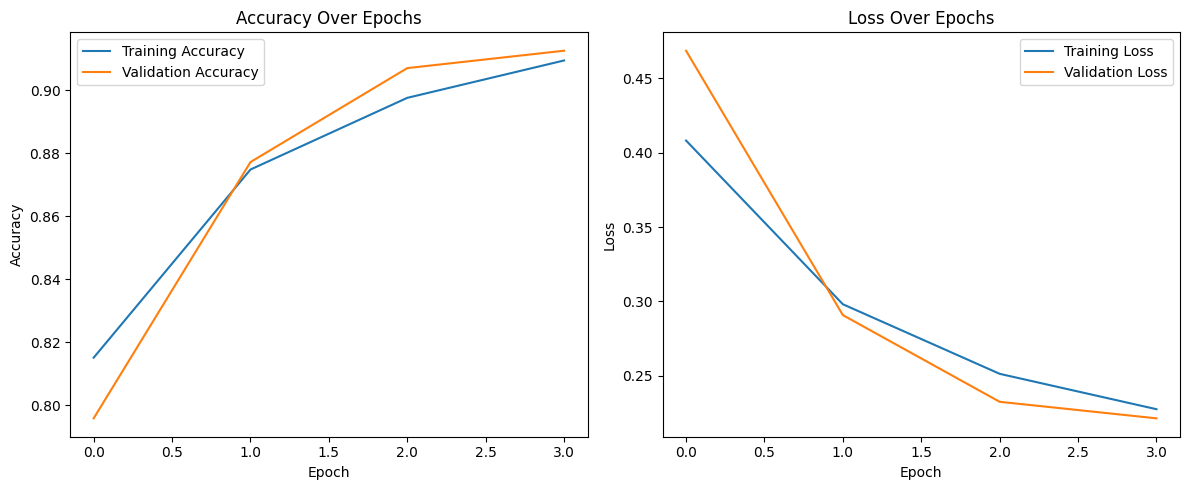

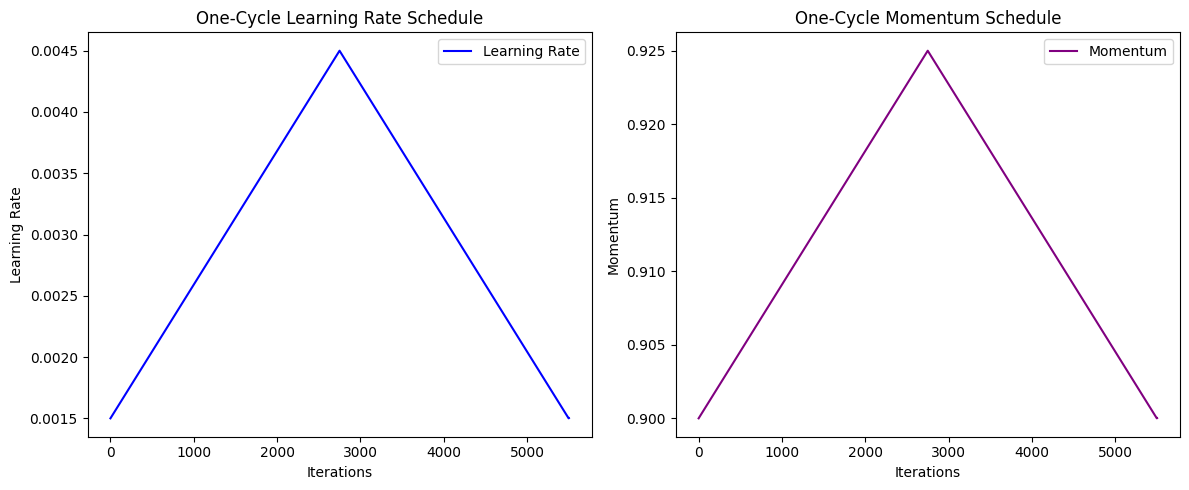

In [27]:
# for accuracy and loss 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# plot accuracy
ax[0].plot(history.history['accuracy'], label='Training Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy Over Epochs')
ax[0].legend()

# plot Loss
ax[1].plot(history.history['loss'], label='Training Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss Over Epochs')
ax[1].legend()
plt.tight_layout()
plt.show()

# get lr and momentum from onecyclelr hist 
learning_rates, momentums = zip(*one_cycle_callback.history)

# for lr and momentum together 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# plot learning rate schedule
ax[0].plot(learning_rates, label='Learning Rate', color='blue')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Learning Rate')
ax[0].set_title('One-Cycle Learning Rate Schedule')
ax[0].legend()

# plot momentum schedule
ax[1].plot(momentums, label='Momentum', color='purple')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Momentum')
ax[1].set_title('One-Cycle Momentum Schedule')
ax[1].legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in exp
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in multiply
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io


344/344 [==============================] - 213s 612ms/step


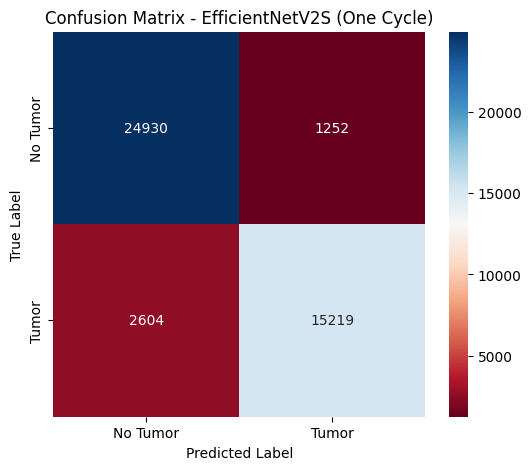

              precision    recall  f1-score   support

    No Tumor       0.91      0.95      0.93     26182
       Tumor       0.92      0.85      0.89     17823

    accuracy                           0.91     44005
   macro avg       0.91      0.90      0.91     44005
weighted avg       0.91      0.91      0.91     44005



In [28]:
# get true labels and predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0) # extract labels
y_pred_probs = model.predict(val_ds) # get predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int).flatten() # convert to binary predictions

conf_matrix = confusion_matrix(y_true, y_pred)

# plot confusion matrix as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="RdBu", xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - EfficientNetV2S (One Cycle)")
plt.show()

# classification report
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))

### Visualizing Misclassified Images

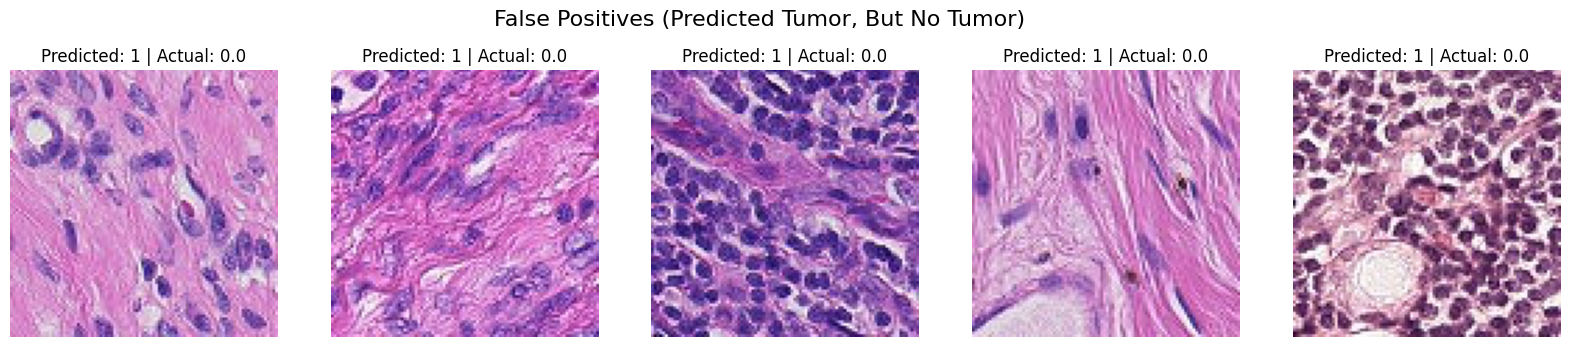

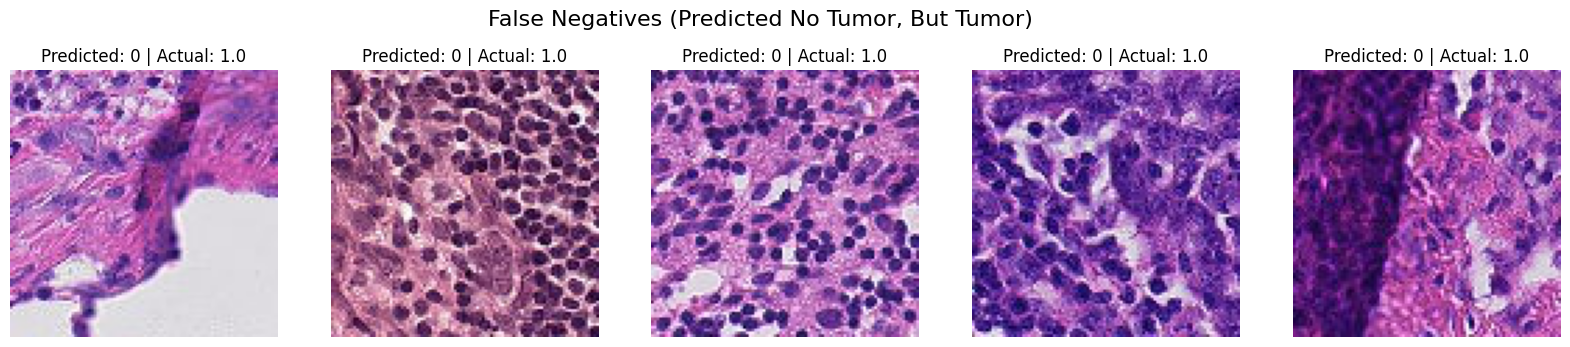

In [29]:
# val image paths 
image_paths_val = [os.path.join(train_path, img_id + ".tif") for img_id in val_df['id']]
# misclassified indices
false_positives = np.where((y_pred == 1) & (y_true == 0))[0] # FP: predicted tumor, but no tumor
false_negatives = np.where((y_pred == 0) & (y_true == 1))[0] # FN: predicted no tumor, but tumor

def plot_misclassified(images, labels, title, num_samples=5):
    """Plot misclassified images with their predictions"""
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    for i, idx in enumerate(images[:num_samples]):
        img_path = image_paths_val[idx]  
        img = cv2.imread(img_path) # load image w/o re-augmentation
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB conversion 
        axes[i].imshow(img)  
        axes[i].axis("off")
        axes[i].set_title(f"Predicted: {y_pred[idx]} | Actual: {labels[idx]}", fontsize=12)

    plt.show()

# false positives
plot_misclassified(false_positives, y_true, "False Positives (Predicted Tumor, But No Tumor)")
# false negatives
plot_misclassified(false_negatives, y_true, "False Negatives (Predicted No Tumor, But Tumor)")

### Baseline Model Misclassified Results Analysis
False Positives:

- Appear lighter in staining overall
- More fibroblasts (these are the cells that look spindle shaped)

False Negatives:

- Appear darker in staining overall
- Nuclei appear closely packed
- Clear patterns in edges


Possible Improvements:
Variations in the staining and texture seem to be the contributing to misclassification most. I will try to apply stain normalization to reduce variance between slides so the model can focus in on the actual shape of tumerous cells. I report the results of this experiment here: After applying macenko normalization, I achieve very similar results. False negatives still have clear edge patterns and appear a little darker in staining. 

### 4. Implementing Vision Transformer (ViT Hybrid) Model
Here, I rebuild EfficientNetV2 and integrate transformer layers (Multi-Head Attention) on top. However, I do not use the One Cycle Policy here because it was created for CNN-based architectures. ViT requires a different training strategy, so, I use the trained EfficientNetV2S as a feature extractor and train the ViT-Hybrid model from scratch to better align with transformer learning dynamics.


I use 8 attention heads because the number of attention heads is chosen based on the feature space size. More heads improve feature representation but increase memory usage. Since EfficientNetV2S already extracts rich features, 8 attention heads is a good balance between performance and efficiency. I chose key dimension = 64 because the key dimension controls how much each attention head focuses on different features. Common choices are 32, 64, 96, and 128. But if it is too low (32), the model may lack expressiveness. By contrast, if it is too high (128), there are more parameters, leading to overfitting and slower training.

To provide stable convergence, AdamW is used instead of SGD, and a Cosine Decay Schedule progressively lowers the learning rate. Training follows a 4 phase approach to progressively fine-tune different layers. In Phase 1, the EfficientNetV2S backbone is frozen, training only the classification head (128 → 1) for 7 epochs with a starting learning rate of 1e-4. Phase 2 unfreezes attention layers while keeping the EfficientNetV2S backbone frozen, reducing the LR to 1/3 of the initial value and training for 7 more epochs. In Phase 3, the last 100 layers of EfficientNetV2 are unfreezed, lowering the LR to 1/5 to prevent  forgetting and training for 5 epochs. Finally, in Phase 4, all layers are unfrozen (except BatchNorm), with the final LR reduced to 1/10 of the initial value. A Cosine Decay Schedule is applied over 15 epochs to ensure smooth convergence and prevent instability.

In [ ]:
initial_lr = 1e-4
min_lr = initial_lr / 20 # avoid division instability

# cosine decay schedule bc Transformers need gradual LR reduction for convergence
def cosine_decay(epoch, lr):
    lr = initial_lr * 0.5 * (1 + np.cos(np.pi * epoch / 15))
    return max(lr, min_lr)

# callbacks for initial training
callbacks_vit = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)]

# callbacks for fine tuning
callbacks_vit_finetune = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=5e-7),
                          tf.keras.callbacks.ModelCheckpoint(filepath='vit_hybrid_finetuned_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min', verbose=1),
                          tf.keras.callbacks.LearningRateScheduler(cosine_decay)]


# minimal positional embeddings added to attention layer
class PositionalEmbedding(Layer):
    def __init__(self, num_patches, embedding_dim):
        super(PositionalEmbedding, self).__init__()
        self.pos_embedding = self.add_weight("pos_embedding", shape=(1, num_patches, embedding_dim), initializer="random_normal")

    def call(self, inputs):
        return inputs + self.pos_embedding

def build_vit_hybrid(input_shape=(crop_size, crop_size, 3), num_heads=8, key_dim=64, dropout_rate=0.4, l2_reg=0.00005, use_pretrained_backbone=True):
    # load trained EfficientNetV2S but get rid of classification head
    base_model = tf.keras.models.load_model("efficientnet_trained_model.h5", compile=False)
    # rebuild w/o last classification layers to only extract convolutional backbone
    base_model = Model(inputs=base_model.input, outputs=base_model.get_layer('top_conv').output)  


    x = base_model.output
    h, w, c = x.shape[1:]
    x = Reshape((h * w, c))(x)

    # positional embeddings
    num_patches = h * w
    x = PositionalEmbedding(num_patches, c)(x)

    # transformer attention block
    x_norm = LayerNormalization()(x)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x_norm, x_norm)
    x = Add()([x_norm, attn_output]) # residual connection

    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid', dtype="float32")(x) 

    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

model_vit_hybrid, base_model = build_vit_hybrid(input_shape=(crop_size, crop_size, 3), dropout_rate=0.3, l2_reg=0.05, use_pretrained_backbone=True)

# freeze EfficientNetV2S backbone
print("Phase 1: Training classification head...")
for layer in base_model.layers:
    layer.trainable = False

# compile w label smoothing and gradient clipping
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.05)

optimizer = tf.keras.mixed_precision.LossScaleOptimizer(AdamW(learning_rate= initial_lr, weight_decay=0.015, clipnorm=1.0),  # reduce lr for smooth start
                                                        dynamic=True,
                                                        initial_scale=2**4) # lower initial scale to prevent inf loss

model_vit_hybrid.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', AUC(name='auc')])

# train classification head
print("Training classification head...")
history_phase1 = model_vit_hybrid.fit(train_ds, validation_data=val_ds, epochs=7, callbacks=callbacks_vit)

# warmup phase for attention layers
print("Phase 2: Warming up attention layers...")
for layer in model_vit_hybrid.layers:
    if isinstance(layer, MultiHeadAttention):
        layer.trainable = True
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(AdamW(learning_rate= initial_lr/3, weight_decay=0.015, clipnorm=1.0),  # reduce lr for smooth start
                                                        dynamic=True,
                                                        initial_scale=2**4) # lower initial scale to prevent inf loss

model_vit_hybrid.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', AUC(name='auc')])
history_phase2 = model_vit_hybrid.fit(train_ds, validation_data=val_ds, epochs=7, callbacks=callbacks_vit)

# fine tuning phase (last 100 layers)
print("Phase 3: Fine-tuning last layers...")
for i, layer in enumerate(base_model.layers):
    if i >= len(base_model.layers) - 100: # unfreeze last 100 layers
        layer.trainable = True

# reinitialize optimizer to recognize new trainable layers
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(AdamW(learning_rate=initial_lr/5, clipnorm=1.0),
                                                        dynamic=True,
                                                        initial_scale=2**7)

# rebuild the optimizer state for newly trainable variables
optimizer.build(model_vit_hybrid.trainable_variables)  

# recompile the model with updated optimizer
model_vit_hybrid.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', AUC(name='auc')])

# train last 100 layers
history_phase3 = model_vit_hybrid.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=callbacks_vit)

# unfreeze everything except batchnorm
print("Phase 4: Fine-tuning entire model...")
for layer in base_model.layers:
    layer.trainable = True
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False # keep batchnorm frozen

# final fine tuning w cosine decay
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(AdamW(learning_rate=initial_lr/10, clipnorm=1.0),
                                                        dynamic=True,
                                                        initial_scale=2**7 # loss scale to avoid inf loss
                                                       )
optimizer.build(model_vit_hybrid.trainable_variables) 
model_vit_hybrid.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', AUC(name='auc')])
history_vit_hybrid = model_vit_hybrid.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=callbacks_vit_finetune)

Phase 1: Training classification head...
Training classification head...
Epoch 1/7


2025-02-19 03:14:33.794154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2147 of 10000
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in exp
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in multiply
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
2025-02-19 03:14:43.798372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4291 of 10000
2025-02-19 03:14:53.778938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6481 of 10000
2025-02-19 03:15:03.781119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8625 of 10000
2025-02-19 03:15:10.143055: I tensorflow/core/kernels/data/shuffle_datase

1376/1376 [==============================] - 1110s 765ms/step - loss: 1.2044 - accuracy: 0.9094 - auc: 0.9618 - val_loss: 0.3181 - val_accuracy: 0.9125 - val_auc: 0.9675 - lr: 1.0000e-04
Epoch 2/7


2025-02-19 03:32:55.475683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2147 of 10000
2025-02-19 03:33:05.468674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4297 of 10000
2025-02-19 03:33:15.527340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6529 of 10000
2025-02-19 03:33:25.476619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8760 of 10000
2025-02-19 03:33:31.341828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1058s 735ms/step - loss: 0.3248 - accuracy: 0.9116 - auc: 0.9634 - val_loss: 0.3174 - val_accuracy: 0.9133 - val_auc: 0.9679 - lr: 1.0000e-04
Epoch 3/7


2025-02-19 03:50:33.300293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2205 of 10000
2025-02-19 03:50:43.315275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4296 of 10000
2025-02-19 03:50:53.301604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6436 of 10000
2025-02-19 03:51:03.296549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8391 of 10000
2025-02-19 03:51:10.862718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1110s 772ms/step - loss: 0.3213 - accuracy: 0.9127 - auc: 0.9639 - val_loss: 0.3152 - val_accuracy: 0.9146 - val_auc: 0.9668 - lr: 1.0000e-04
Epoch 4/7


2025-02-19 04:09:03.630483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2112 of 10000
2025-02-19 04:09:13.644673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4260 of 10000
2025-02-19 04:09:23.640146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6455 of 10000
2025-02-19 04:09:33.640748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8741 of 10000
2025-02-19 04:09:39.616149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1050s 730ms/step - loss: 0.3165 - accuracy: 0.9132 - auc: 0.9647 - val_loss: 0.3135 - val_accuracy: 0.9156 - val_auc: 0.9677 - lr: 1.0000e-04
Epoch 5/7


2025-02-19 04:26:33.872301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2142 of 10000
2025-02-19 04:26:43.898290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4293 of 10000
2025-02-19 04:26:53.881303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6348 of 10000
2025-02-19 04:27:03.873296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8439 of 10000
2025-02-19 04:27:11.306000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1043s 724ms/step - loss: 0.3145 - accuracy: 0.9135 - auc: 0.9648 - val_loss: 0.3121 - val_accuracy: 0.9156 - val_auc: 0.9676 - lr: 1.0000e-04
Epoch 6/7


2025-02-19 04:43:57.040240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2156 of 10000
2025-02-19 04:44:07.039392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4336 of 10000
2025-02-19 04:44:17.048837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6529 of 10000
2025-02-19 04:44:27.093736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8674 of 10000
2025-02-19 04:44:33.008713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1040s 722ms/step - loss: 0.3103 - accuracy: 0.9145 - auc: 0.9655 - val_loss: 0.3027 - val_accuracy: 0.9141 - val_auc: 0.9688 - lr: 1.0000e-04
Epoch 7/7


2025-02-19 05:01:16.925245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2163 of 10000
2025-02-19 05:01:26.953868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4372 of 10000
2025-02-19 05:01:36.960759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6487 of 10000
2025-02-19 05:01:46.932939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8701 of 10000
2025-02-19 05:01:52.859571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1040s 722ms/step - loss: 0.3074 - accuracy: 0.9141 - auc: 0.9659 - val_loss: 0.3065 - val_accuracy: 0.9170 - val_auc: 0.9688 - lr: 1.0000e-04
Phase 2: Warming up attention layers...
Epoch 1/7


2025-02-19 05:18:45.616921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2160 of 10000
2025-02-19 05:18:55.610528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4321 of 10000
2025-02-19 05:19:05.634138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6477 of 10000
2025-02-19 05:19:15.629675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8664 of 10000
2025-02-19 05:19:21.789176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1053s 724ms/step - loss: 0.2934 - accuracy: 0.9156 - auc: 0.9672 - val_loss: 0.2898 - val_accuracy: 0.9158 - val_auc: 0.9689 - lr: 3.3333e-05
Epoch 2/7


2025-02-19 05:36:09.820390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2177 of 10000
2025-02-19 05:36:19.840968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4296 of 10000
2025-02-19 05:36:29.827700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6450 of 10000
2025-02-19 05:36:39.854767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8640 of 10000
2025-02-19 05:36:46.000028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1089s 758ms/step - loss: 0.2917 - accuracy: 0.9158 - auc: 0.9675 - val_loss: 0.2903 - val_accuracy: 0.9175 - val_auc: 0.9696 - lr: 3.3333e-05
Epoch 3/7


2025-02-19 05:54:18.938619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2189 of 10000
2025-02-19 05:54:28.943155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4359 of 10000
2025-02-19 05:54:38.950540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6560 of 10000
2025-02-19 05:54:48.948532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8756 of 10000
2025-02-19 05:54:54.638277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1092s 760ms/step - loss: 0.2912 - accuracy: 0.9166 - auc: 0.9677 - val_loss: 0.2898 - val_accuracy: 0.9160 - val_auc: 0.9690 - lr: 3.3333e-05
Epoch 4/7


2025-02-19 06:12:30.617976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2119 of 10000
2025-02-19 06:12:40.652510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4254 of 10000
2025-02-19 06:12:50.610021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6461 of 10000
2025-02-19 06:13:00.638321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8614 of 10000
2025-02-19 06:13:06.959490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1090s 758ms/step - loss: 0.2904 - accuracy: 0.9165 - auc: 0.9680 - val_loss: 0.2896 - val_accuracy: 0.9174 - val_auc: 0.9698 - lr: 3.3333e-05
Epoch 5/7


2025-02-19 06:30:40.768190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2225 of 10000
2025-02-19 06:30:50.784568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4440 of 10000
2025-02-19 06:31:00.738291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6585 of 10000
2025-02-19 06:31:10.743997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8809 of 10000
2025-02-19 06:31:16.323324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1091s 760ms/step - loss: 0.2898 - accuracy: 0.9166 - auc: 0.9682 - val_loss: 0.2868 - val_accuracy: 0.9176 - val_auc: 0.9695 - lr: 3.3333e-05
Epoch 6/7


2025-02-19 06:48:51.868343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2139 of 10000
2025-02-19 06:49:01.829463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4262 of 10000
2025-02-19 06:49:11.821205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6437 of 10000
2025-02-19 06:49:21.836371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8623 of 10000
2025-02-19 06:49:28.102360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1045s 726ms/step - loss: 0.2895 - accuracy: 0.9166 - auc: 0.9685 - val_loss: 0.2878 - val_accuracy: 0.9170 - val_auc: 0.9693 - lr: 3.3333e-05
Epoch 7/7


2025-02-19 07:06:17.287367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2149 of 10000
2025-02-19 07:06:27.264842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4315 of 10000
2025-02-19 07:06:37.233910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6487 of 10000
2025-02-19 07:06:47.244953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8617 of 10000
2025-02-19 07:06:53.325721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1093s 761ms/step - loss: 0.2893 - accuracy: 0.9163 - auc: 0.9683 - val_loss: 0.2866 - val_accuracy: 0.9178 - val_auc: 0.9698 - lr: 3.3333e-05
Phase 3: Fine-tuning last layers...
Epoch 1/5


2025-02-19 07:24:42.890402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2166 of 10000
2025-02-19 07:24:52.917533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4347 of 10000
2025-02-19 07:25:02.886784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6519 of 10000
2025-02-19 07:25:12.914916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8637 of 10000
2025-02-19 07:25:19.295405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1109s 759ms/step - loss: 0.2877 - accuracy: 0.9163 - auc: 0.9683 - val_loss: 0.2831 - val_accuracy: 0.9185 - val_auc: 0.9703 - lr: 2.0000e-05
Epoch 2/5


2025-02-19 07:42:59.584585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2207 of 10000
2025-02-19 07:43:09.564613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4380 of 10000
2025-02-19 07:43:19.573886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6560 of 10000
2025-02-19 07:43:29.578770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8761 of 10000
2025-02-19 07:43:35.160072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1094s 762ms/step - loss: 0.2853 - accuracy: 0.9175 - auc: 0.9689 - val_loss: 0.2831 - val_accuracy: 0.9195 - val_auc: 0.9706 - lr: 2.0000e-05
Epoch 3/5


2025-02-19 08:01:13.745350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2101 of 10000
2025-02-19 08:01:23.743062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4287 of 10000
2025-02-19 08:01:33.728043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6417 of 10000
2025-02-19 08:01:43.728245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8549 of 10000
2025-02-19 08:01:50.524930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1044s 724ms/step - loss: 0.2852 - accuracy: 0.9174 - auc: 0.9690 - val_loss: 0.2828 - val_accuracy: 0.9177 - val_auc: 0.9704 - lr: 2.0000e-05
Epoch 4/5


2025-02-19 08:18:37.656228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2173 of 10000
2025-02-19 08:18:47.637601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4200 of 10000
2025-02-19 08:18:57.631757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6354 of 10000
2025-02-19 08:19:07.641795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8565 of 10000
2025-02-19 08:19:14.206588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1049s 728ms/step - loss: 0.2845 - accuracy: 0.9178 - auc: 0.9691 - val_loss: 0.2822 - val_accuracy: 0.9192 - val_auc: 0.9703 - lr: 2.0000e-05
Epoch 5/5


2025-02-19 08:36:06.165520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2203 of 10000
2025-02-19 08:36:16.181170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4325 of 10000
2025-02-19 08:36:26.175673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6457 of 10000
2025-02-19 08:36:36.191895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8609 of 10000
2025-02-19 08:36:42.632718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - 1096s 763ms/step - loss: 0.2834 - accuracy: 0.9181 - auc: 0.9696 - val_loss: 0.2822 - val_accuracy: 0.9192 - val_auc: 0.9711 - lr: 2.0000e-05
Phase 4: Fine-tuning entire model...
Epoch 1/15


2025-02-19 08:54:46.506492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2115 of 10000
2025-02-19 08:54:56.497547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4306 of 10000
2025-02-19 08:55:06.505299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6490 of 10000
2025-02-19 08:55:16.502170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8644 of 10000
2025-02-19 08:55:22.720943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.9114 - auc: 0.9627      
Epoch 1: val_loss improved from inf to 0.32957, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1131s 762ms/step - loss: 0.3095 - accuracy: 0.9114 - auc: 0.9627 - val_loss: 0.3296 - val_accuracy: 0.8990 - val_auc: 0.9671 - lr: 1.0000e-04
Epoch 2/15


2025-02-19 09:13:13.754180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2199 of 10000
2025-02-19 09:13:23.759717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4352 of 10000
2025-02-19 09:13:33.759372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6559 of 10000
2025-02-19 09:13:43.779734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8779 of 10000
2025-02-19 09:13:49.359590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.2825 - accuracy: 0.9239 - auc: 0.9708      
Epoch 2: val_loss improved from 0.32957 to 0.27980, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1043s 725ms/step - loss: 0.2825 - accuracy: 0.9239 - auc: 0.9708 - val_loss: 0.2798 - val_accuracy: 0.9252 - val_auc: 0.9763 - lr: 9.8907e-05
Epoch 3/15


2025-02-19 09:30:37.207641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2157 of 10000
2025-02-19 09:30:47.173770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4291 of 10000
2025-02-19 09:30:57.172223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6377 of 10000
2025-02-19 09:31:07.212354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8540 of 10000
2025-02-19 09:31:14.213002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.9303 - auc: 0.9742      
Epoch 3: val_loss did not improve from 0.27980
1376/1376 [==============================] - 1045s 725ms/step - loss: 0.2696 - accuracy: 0.9303 - auc: 0.9742 - val_loss: 0.2836 - val_accuracy: 0.9200 - val_auc: 0.9779 - lr: 9.5677e-05
Epoch 4/15


2025-02-19 09:48:02.135164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2174 of 10000
2025-02-19 09:48:12.163035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4318 of 10000
2025-02-19 09:48:22.129749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6518 of 10000
2025-02-19 09:48:32.159829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8643 of 10000
2025-02-19 09:48:38.200421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.9369 - auc: 0.9775      
Epoch 4: val_loss improved from 0.27980 to 0.24990, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1038s 721ms/step - loss: 0.2578 - accuracy: 0.9369 - auc: 0.9775 - val_loss: 0.2499 - val_accuracy: 0.9393 - val_auc: 0.9813 - lr: 9.0451e-05
Epoch 5/15


2025-02-19 10:05:20.500683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2219 of 10000
2025-02-19 10:05:30.486472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4413 of 10000
2025-02-19 10:05:40.492906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6590 of 10000
2025-02-19 10:05:50.491177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8764 of 10000
2025-02-19 10:05:55.888616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.9416 - auc: 0.9804      
Epoch 5: val_loss improved from 0.24990 to 0.24513, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1041s 724ms/step - loss: 0.2459 - accuracy: 0.9416 - auc: 0.9804 - val_loss: 0.2451 - val_accuracy: 0.9398 - val_auc: 0.9821 - lr: 8.3457e-05
Epoch 6/15


2025-02-19 10:22:42.011312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2242 of 10000
2025-02-19 10:22:51.993240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4447 of 10000
2025-02-19 10:23:01.983015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6601 of 10000
2025-02-19 10:23:12.009887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8791 of 10000
2025-02-19 10:23:17.434960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.9458 - auc: 0.9824      
Epoch 6: val_loss improved from 0.24513 to 0.23781, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1042s 724ms/step - loss: 0.2374 - accuracy: 0.9458 - auc: 0.9824 - val_loss: 0.2378 - val_accuracy: 0.9441 - val_auc: 0.9838 - lr: 7.5000e-05
Epoch 7/15


2025-02-19 10:40:04.128089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2155 of 10000
2025-02-19 10:40:14.117595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4379 of 10000
2025-02-19 10:40:24.134771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6524 of 10000
2025-02-19 10:40:34.138894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8696 of 10000
2025-02-19 10:40:40.013565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9498 - auc: 0.9843      
Epoch 7: val_loss improved from 0.23781 to 0.22801, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1094s 761ms/step - loss: 0.2288 - accuracy: 0.9498 - auc: 0.9843 - val_loss: 0.2280 - val_accuracy: 0.9486 - val_auc: 0.9857 - lr: 6.5451e-05
Epoch 8/15


2025-02-19 10:58:17.868166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2173 of 10000
2025-02-19 10:58:27.886644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4388 of 10000
2025-02-19 10:58:37.861496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6546 of 10000
2025-02-19 10:58:47.851844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8735 of 10000
2025-02-19 10:58:53.638964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9536 - auc: 0.9862      
Epoch 8: val_loss did not improve from 0.22801
1376/1376 [==============================] - 1038s 721ms/step - loss: 0.2203 - accuracy: 0.9536 - auc: 0.9862 - val_loss: 0.2298 - val_accuracy: 0.9471 - val_auc: 0.9853 - lr: 5.5226e-05
Epoch 9/15


2025-02-19 11:15:35.945006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2250 of 10000
2025-02-19 11:15:45.943555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4485 of 10000
2025-02-19 11:15:55.969992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6688 of 10000
2025-02-19 11:16:05.950163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8875 of 10000
2025-02-19 11:16:10.925477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9571 - auc: 0.9879      
Epoch 9: val_loss improved from 0.22801 to 0.22437, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1094s 762ms/step - loss: 0.2119 - accuracy: 0.9571 - auc: 0.9879 - val_loss: 0.2244 - val_accuracy: 0.9513 - val_auc: 0.9874 - lr: 4.4774e-05
Epoch 10/15


2025-02-19 11:33:50.158344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2213 of 10000
2025-02-19 11:34:00.157678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4381 of 10000
2025-02-19 11:34:10.204610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6609 of 10000
2025-02-19 11:34:20.171019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8856 of 10000
2025-02-19 11:34:25.405274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9606 - auc: 0.9893      
Epoch 10: val_loss improved from 0.22437 to 0.22289, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1043s 725ms/step - loss: 0.2042 - accuracy: 0.9606 - auc: 0.9893 - val_loss: 0.2229 - val_accuracy: 0.9516 - val_auc: 0.9876 - lr: 3.4549e-05
Epoch 11/15


2025-02-19 11:51:12.886241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2128 of 10000
2025-02-19 11:51:22.887819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4293 of 10000
2025-02-19 11:51:32.883215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6464 of 10000
2025-02-19 11:51:42.874281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8610 of 10000
2025-02-19 11:51:49.259431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9630 - auc: 0.9902      
Epoch 11: val_loss improved from 0.22289 to 0.21285, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1096s 763ms/step - loss: 0.1987 - accuracy: 0.9630 - auc: 0.9902 - val_loss: 0.2129 - val_accuracy: 0.9545 - val_auc: 0.9884 - lr: 2.5000e-05
Epoch 12/15


2025-02-19 12:09:28.842258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2185 of 10000
2025-02-19 12:09:38.810593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4387 of 10000
2025-02-19 12:09:48.834938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6595 of 10000
2025-02-19 12:09:58.827790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8825 of 10000
2025-02-19 12:10:04.316794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9654 - auc: 0.9914      
Epoch 12: val_loss improved from 0.21285 to 0.21031, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1040s 723ms/step - loss: 0.1928 - accuracy: 0.9654 - auc: 0.9914 - val_loss: 0.2103 - val_accuracy: 0.9558 - val_auc: 0.9886 - lr: 1.6543e-05
Epoch 13/15


2025-02-19 12:26:49.047886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2137 of 10000
2025-02-19 12:26:59.076183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4308 of 10000
2025-02-19 12:27:09.096311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6446 of 10000
2025-02-19 12:27:19.064250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8650 of 10000
2025-02-19 12:27:25.221464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9683 - auc: 0.9921      
Epoch 13: val_loss improved from 0.21031 to 0.20983, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1099s 765ms/step - loss: 0.1877 - accuracy: 0.9683 - auc: 0.9921 - val_loss: 0.2098 - val_accuracy: 0.9568 - val_auc: 0.9892 - lr: 9.5492e-06
Epoch 14/15


2025-02-19 12:45:07.753257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2126 of 10000
2025-02-19 12:45:17.752578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4328 of 10000
2025-02-19 12:45:27.759869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6533 of 10000
2025-02-19 12:45:37.796242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8718 of 10000
2025-02-19 12:45:43.620046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9687 - auc: 0.9925      
Epoch 14: val_loss improved from 0.20983 to 0.20770, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1096s 763ms/step - loss: 0.1862 - accuracy: 0.9687 - auc: 0.9925 - val_loss: 0.2077 - val_accuracy: 0.9569 - val_auc: 0.9897 - lr: 5.0000e-06
Epoch 15/15


2025-02-19 13:03:23.632412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2194 of 10000
2025-02-19 13:03:33.611277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 4399 of 10000
2025-02-19 13:03:43.634537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 6600 of 10000
2025-02-19 13:03:53.673632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 8802 of 10000
2025-02-19 13:03:59.243165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1376/1376 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9698 - auc: 0.9924      
Epoch 15: val_loss improved from 0.20770 to 0.20636, saving model to vit_hybrid_finetuned_model.h5
1376/1376 [==============================] - 1040s 723ms/step - loss: 0.1846 - accuracy: 0.9698 - auc: 0.9924 - val_loss: 0.2064 - val_accuracy: 0.9583 - val_auc: 0.9896 - lr: 5.0000e-06


### Evaluate Performance

The ViT-Hybrid model achieved a validation accuracy of 95.84% and an AUC of 0.9900, showing stronger performance in distinguishing tumor from non-tumor patches. The confusion matrix shows improved recall for both no tumore detection (0.97) and tumor detection (0.94) compared to EfficientNetV2S, meaning that ViT-Hybrid captures long range dependencies effectively. However, the validation accuracy curve suggests some fluctuations, likely due to the sensitivity of attention mechanisms to hyperparameter tuning. Despite this, the higher F1-score (0.96/.95) across both classes proves the model's balanced performance, making it a great alternative to pure CNN-based architectures for histopathology classification. 

In [33]:
test_loss_vit, test_accuracy_vit, test_auc_vit = model_vit_hybrid.evaluate(val_ds)
print(f"ViT-Hybrid Validation Accuracy: {test_accuracy_vit:.4f}")
print(f"ViT-Hybrid Validation AUC: {test_auc_vit:.4f}")
print(f"ViT-Hybrid Validation Loss: {test_loss_vit:.4f}")

 32/344 [=>............................] - ETA: 3:08 - loss: 0.2121 - accuracy: 0.9548 - auc: 0.9886

/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in exp
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in multiply
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io


344/344 [==============================] - 208s 605ms/step - loss: 0.2060 - accuracy: 0.9584 - auc: 0.9900
ViT-Hybrid Validation Accuracy: 0.9584
ViT-Hybrid Validation AUC: 0.9900
ViT-Hybrid Validation Loss: 0.2060


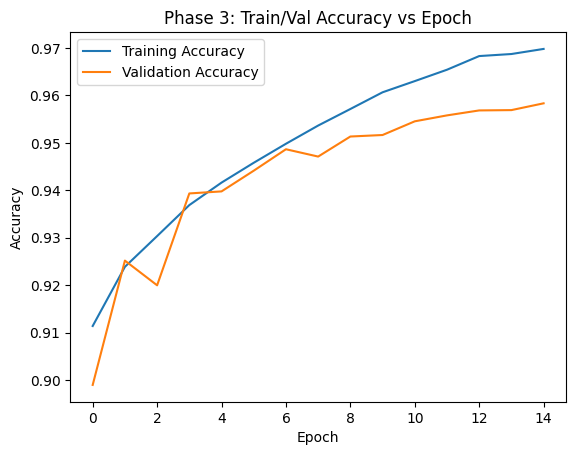

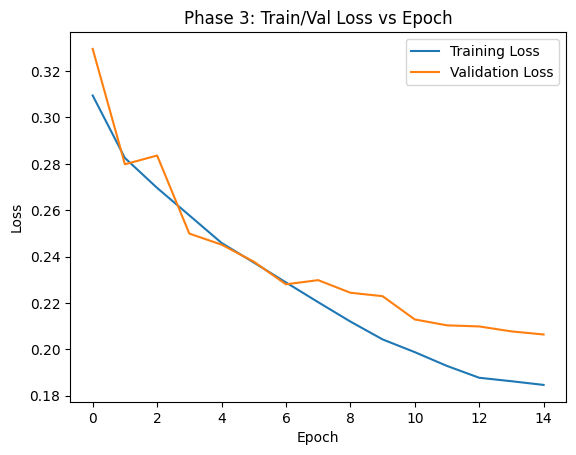

In [34]:
# plot accuracy
plt.plot(history_vit_hybrid.history['accuracy'], label='Training Accuracy')
plt.plot(history_vit_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title('Phase 3: Train/Val Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot loss
plt.plot(history_vit_hybrid.history['loss'], label='Training Loss')
plt.plot(history_vit_hybrid.history['val_loss'], label='Validation Loss')
plt.title('Phase 3: Train/Val Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in exp
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
/tmp/ipykernel_8589/1829717462.py:54: RuntimeWarning: overflow encountered in multiply
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io


344/344 [==============================] - 210s 605ms/step


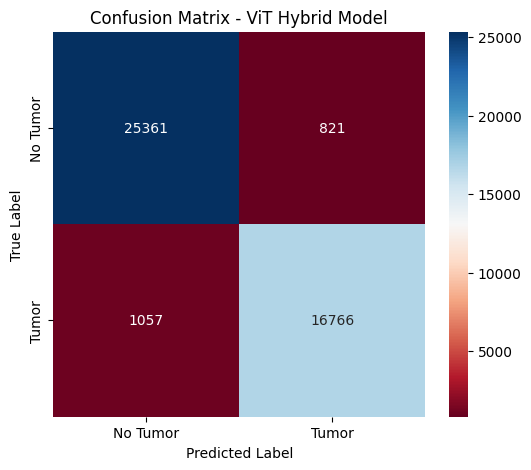

              precision    recall  f1-score   support

    No Tumor       0.96      0.97      0.96     26182
       Tumor       0.95      0.94      0.95     17823

    accuracy                           0.96     44005
   macro avg       0.96      0.95      0.96     44005
weighted avg       0.96      0.96      0.96     44005



In [35]:
# get true labels and predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0) # extract labels
y_pred_probs = model_vit_hybrid.predict(val_ds) # get predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int).flatten() # convert to binary predictions

conf_matrix = confusion_matrix(y_true, y_pred)

# plot confusion matrix as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="RdBu", xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ViT Hybrid Model")
plt.show()

# classification report
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))

### Final Model Comparison and Kaggle Submission

Test-Time Augmentation (TTA) is applied during inference to improve model robustness by averaging predictions from multiple augmented versions of the same image. Unlike training augmentation, which helps with generalization, TTA helps reduce prediction variance by simulating different  transformations of each test image. Here, the same augmentation performed during training are randomly applied to create 30 augmented versions per test image. The final prediction is obtained by averaging across all iterations. The best-performing model (ViT-Hybrid) is automatically selected based on validation AUC, ensuring optimal performance for final submission.

In [39]:
# constants
original_size = 96 # DO NOT CHANGE
crop_size = 90 # final crop size

# augmentation parameters
random_rotation = 3 # degrees
random_shift = 3  # pixel shift for cropping
random_brightness = 0.1 # brightness adjustment (scaled to 0-1, converted to 0-255)
random_contrast = 0.1 # contrast adjustment
random_90_degree_turn = True # random 90 degree rotation

# elastic deformation 
alpha = 2.0 # scaling factor for deformation
sigma = 0.05 * crop_size # smoothing factor

# noise
noise_stddev = 5 # stdev of Gaussian noise

def read_cropped_image(path, augment=True):
    """Reads an image, applies augmentations, and returns normalized cropped image"""
    # read image (OpenCV loads BGR format)
    img = cv2.imread(path)

    # handle missing or corrupted images
    if img is None:
        print(f"Failed to load image {path}. Returning blank image")
        return np.zeros((crop_size, crop_size, 3), dtype=np.float32)

    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # if no augmentations, crop and return normalized image
    if not augment:
        start_crop = (original_size - crop_size) // 2 # center crop
        img = img[start_crop:start_crop+crop_size, start_crop:start_crop+crop_size] / 255.0
        return img.astype(np.float32)

    # image augmentations
    img = macenko_normalization(img, ref_img=reference_image)
    
    # random rotation
    angle = random.randint(-random_rotation, random_rotation)
    if random_90_degree_turn:
        angle += random.choice([0, 90, -90, 180])
    transformation_matrix = cv2.getRotationMatrix2D((original_size // 2, original_size // 2), angle, 1)
    img = cv2.warpAffine(img, transformation_matrix, (original_size, original_size), borderMode=cv2.BORDER_REFLECT_101) 

    # random shift
    x_shift = random.randint(-random_shift, random_shift)
    y_shift = random.randint(-random_shift, random_shift)
    start_crop = (original_size - crop_size) // 2
    img = img[start_crop + y_shift:start_crop + y_shift + crop_size, start_crop + x_shift:start_crop + x_shift + crop_size]

    # random Flip
    if random.random() < 0.5:
        img = cv2.flip(img, 1) # horizontal 
    if random.random() < 0.2:
        img = cv2.flip(img, 0) # vertical 

    # hue shift 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hue_shift = random.randint(-5, 5)
    hsv[:, :, 0] = np.clip(hsv[:, :, 0] + hue_shift, 0, 179)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # elastic deformation 
    dx = cv2.GaussianBlur((np.random.rand(*img.shape[:2]) * 2 - 1), (17, 17), sigma) * alpha
    dy = cv2.GaussianBlur((np.random.rand(*img.shape[:2]) * 2 - 1), (17, 17), sigma) * alpha
    x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)
    img = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    # random brightness/contrast
    brightness = random.uniform(-random_brightness, random_brightness) * 255 # scale brightness 
    contrast = random.uniform(1.0 - random_contrast, 1.0 + random_contrast)
    img = np.clip(contrast * img + brightness, 0, 255).astype(np.float32)

    # Gaussian noise
    noise_stddev_scaled = max(noise_stddev, 0.05 * np.mean(img))
    noise = np.random.normal(0, noise_stddev_scaled, img.shape).astype(np.float32)
    img = np.clip(img + noise, 0, 255).astype(np.float32)

    # normalize to [0,1]
    img /= 255.0

    return img

# imageNet mean and std for normalization
imagenet_mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
imagenet_std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def normalize_image_for_efficientnet(img):
    """Normalize image using ImageNet statistics for EfficientNetV2"""
    return ((img - imagenet_mean) / imagenet_std).astype(np.float32) 

def preprocess_image(img_path, dataset_type='train', augment=False):
    """Load, crop, scale, and normalize image"""
    if isinstance(img_path, tf.Tensor):
        img_path = img_path.numpy().decode("utf-8") # change tensor to string

    img = read_cropped_image(img_path, augment=augment) # force augmentation for TTA

    return tf.cast(normalize_image_for_efficientnet(img), tf.float16)  

def build_tf_dataset(image_paths, labels=None, batch_size=128, shuffle=True, dataset_type='train', augment=False):
    def load_image(img_path):
        img = tf.py_function(lambda x: preprocess_image(x, dataset_type, augment), [img_path], Tout=tf.float16)
        img.set_shape([crop_size, crop_size, 3]) 
        return img

    if labels is not None:
        # create dataset w labels (for training/validation)
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
        dataset = dataset.map(lambda img, label: (load_image(img), tf.cast(label, tf.float16)), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        # create dataset w/o labels (for test set or TTA)
        dataset = tf.data.Dataset.from_tensor_slices(image_paths)
        dataset = dataset.map(lambda img: load_image(img), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000) 

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# load test dataset
test_paths = np.array([os.path.join(test_path, img_id) for img_id in os.listdir(test_path) if img_id.endswith('.tif')])
test_ds = build_tf_dataset(test_paths, batch_size=128, shuffle=False, dataset_type='test')

# generate preds 
preds_vit = model_vit_hybrid.predict(test_ds).ravel()
preds_eff = model.predict(test_ds).ravel()
test_filenames = [os.path.splitext(os.path.basename(path))[0] for path in test_paths]

# save submissions
pd.DataFrame({'id': test_filenames, 'label': preds_vit}).to_csv('submissions/submission_model_vit_hybrid.csv', index=False)
pd.DataFrame({'id': test_filenames, 'label': preds_eff}).to_csv('submissions/submission_EfficientNetV2S.csv', index=False)

# eval models 
_, _, test_auc_eff = model.evaluate(val_ds)
_, _, test_auc_vit = model_vit_hybrid.evaluate(val_ds)

best_model, best_model_name = (model, "EfficientNetV2S") if test_auc_eff >= test_auc_vit else (model_vit_hybrid, "ViT-Hybrid")
print(f"Best Model Selected: {best_model_name} with AUC: {max(test_auc_eff, test_auc_vit):.4f}")

# TTA Inference and averages preds
def tta_inference(model, test_paths, tta_times=30):
    all_preds = np.zeros((len(test_paths), tta_times))

    for i in range(tta_times):
        print(f"TTA iteration {i+1}/{tta_times}")
        # enable augmentations for TTA
        tta_ds = build_tf_dataset(test_paths, batch_size=128, shuffle=False, dataset_type='test', augment=True)
        tta_preds = model.predict(tta_ds, verbose=1).ravel()
        all_preds[:, i] = tta_preds # keep TTA predictions

    final_preds = np.mean(all_preds, axis=1) # avg across TTA iterations
    return final_preds


tta_preds = tta_inference(best_model, test_paths, tta_times=30)
pd.DataFrame({'id': test_filenames, 'label': tta_preds}).to_csv('submissions/submission_TTA.csv', index=False)
print("Final TTA Submission saved to submission_TTA.csv")

 32/344 [=>............................] - ETA: 3:01 - loss: 0.2318 - accuracy: 0.9097 - auc: 0.9632 

/tmp/ipykernel_619/1725238179.py:53: RuntimeWarning: overflow encountered in exp
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io
/tmp/ipykernel_619/1725238179.py:53: RuntimeWarning: overflow encountered in multiply
  normalized_img = np.exp(-np.dot(stain_matrix_ref.T, concentration).T) * Io


344/344 [==============================] - 203s 585ms/step - loss: 0.2058 - accuracy: 0.9589 - auc: 0.9897
Best Model Selected: ViT-Hybrid with AUC: 0.9897
TTA iteration 1/30
 83/449 [====>.........................] - ETA: 3:38

/tmp/ipykernel_619/1725238179.py:50: RuntimeWarning: divide by zero encountered in divide
  concentration *= (max_concentration / np.percentile(concentration, alpha, axis=1, keepdims=True))
/tmp/ipykernel_619/1725238179.py:50: RuntimeWarning: invalid value encountered in multiply
  concentration *= (max_concentration / np.percentile(concentration, alpha, axis=1, keepdims=True))
/tmp/ipykernel_619/1725238179.py:63: RuntimeWarning: invalid value encountered in cast
  return (normalized_img).astype(np.uint8)


449/449 [==============================] - 270s 601ms/step
TTA iteration 2/30
449/449 [==============================] - 269s 600ms/step
TTA iteration 3/30
449/449 [==============================] - 270s 600ms/step
TTA iteration 4/30
449/449 [==============================] - 272s 606ms/step
TTA iteration 5/30
449/449 [==============================] - 273s 607ms/step
TTA iteration 6/30
449/449 [==============================] - 276s 615ms/step
TTA iteration 7/30
449/449 [==============================] - 275s 612ms/step
TTA iteration 8/30
449/449 [==============================] - 277s 616ms/step
TTA iteration 9/30
449/449 [==============================] - 278s 620ms/step
TTA iteration 10/30
449/449 [==============================] - 276s 614ms/step
TTA iteration 11/30
449/449 [==============================] - 277s 617ms/step
TTA iteration 12/30
449/449 [==============================] - 275s 613ms/step
TTA iteration 13/30
449/449 [==============================] - 274s 610ms/step
T

### EfficientNetV2S Kaggle Submission Results: Private Score: 0.9359 Public Score: 0.9374

### ViT Hybrid Kaggle Submission Results: Private Score: 0.9507 Public Score: 0.9487

### ViT Hybrid Model with TTA Kaggle Submission Results: Private Score: 0.9576 Public Score: 0.9647

### Model Averaging

In [54]:
vit_df = pd.read_csv('submissions/submission_model_vit_hybrid.csv')
eff_df = pd.read_csv('submissions/submission_EfficientNetV2S.csv')
tta_df = pd.read_csv('submissions/submission_TTA.csv')

# merge on id
ensemble_df = vit_df.merge(eff_df, on='id', suffixes=('_vit', '_eff'))
ensemble_df = ensemble_df.merge(tta_df, on='id')
ensemble_df.rename(columns={'label': 'label_tta'}, inplace=True)

# avg predictions
ensemble_df['label'] = (ensemble_df['label_vit'] + ensemble_df['label_eff'] + ensemble_df['label_tta']) / 3

# only keep id and the averaged label
final_submission = ensemble_df[['id', 'label']]

# save to CSV
final_submission.to_csv('submission_ensemble.csv', index=False)
print("Ensembled submission saved to 'submission_ensemble.csv'")

Ensembled submission saved to 'submission_ensemble.csv'


### Model Average Kaggle Submission Results: Private Score: 0.9650 Public Score: 0.9675

In [61]:
# give most weight to TTA then ViT then Eff
weight_vit = 0.3
weight_eff = 0.2
weight_tta = 0.5

# weighted averaging
ensemble_df['label'] = (weight_vit * ensemble_df['label_vit'] + weight_eff * ensemble_df['label_eff'] + weight_tta * ensemble_df['label_tta'])

# only keepid and the weighted label
final_submission = ensemble_df[['id', 'label']]

# save to CSV
final_submission.to_csv('submissions/submission_ensemble_weighted.csv', index=False)
print("Weighted ensemble submission saved to 'submission_ensemble_weighted.csv'")

Weighted ensemble submission saved to 'submission_ensemble_weighted.csv'


### Model Average Weighted Kaggle Submission Results: Private Score: 0.9647 Public Score: 0.9680


# Final Submission Results

![Model Results](images/Histopathologic_Cancer_Kaggle_Leaderboard.png)

The ViT-Hybrid model with TTA achieved the best standalone performance, with a Private Score of 0.9576 and a Public Score of 0.9647, outperforming both EfficientNetV2S (0.9359 Private, 0.9374 Public) and the baseline ViT-Hybrid model (0.9507 Private, 0.9487 Public). Further improvements were achieved through ensemble averaging, where combining EfficientNetV2S, ViT-Hybrid, and TTA predictions led to a Private Score of 0.9650 and a Public Score of 0.9675. A weighted ensemble, giving the most weight to TTA predictions, performed similarly with a Private Score of 0.9647 and a Public Score of 0.9680, slightly refining generalization.

# Conclusions
This project shows the power of combining CNNs and Transformers for histopathologic cancer detection, with ViT-Hybrid outperforming EfficientNetV2S alone. While EfficientNetV2S captured local tissue structures, ViT’s self-attention mechanisms improved tumor region recognition. The One-Cycle Policy helped EfficientNetV2S converge efficiently, while ViT required gradual fine-tuning with cosine decay. Test-Time Augmentation (TTA) further improved robustness, validating that small image variations improve predictions. Ensemble averaging ultimately provided the best final performance, demonstrating the value of model diversity in medical imaging.

However, there are several areas for improvement. Augmentation strategies could be refined more by experimenting with stronger elastic deformations, contrast normalization, and stain augmentation techniques to increase generalization across different staining variations. Additionally, my stain normalization requires improvement, as the current implementation produced images that appeared too purple compared to StainTools examples. This could potentially cause errors in the color deconvolution process. The RuntimeWarning in exp() means there was numerical instability, likely due to large values in the stain matrix transformation. Addressing this by normalizing the concentration matrix or applying logarithmic stabilization could improve consistency.

Further improvements could include longer training schedules to allow ViT to fully converge. Additionally, implementing DeepSpeed or gradient checkpointing could help reduce memory overhead and improve the efficiency of training larger models. Exploring other CNN architectures like ResNet, ConvNeXt, or DenseNet could provide stronger baseline models, and ensembling them with ViT-Hybrid might further increase performance. Finally, extending TTA with more augmentations or using a weighted averaging technique based on confidence scores could also improve final predictions.

Overall, this project highlights the potential of hybrid architectures in medical image analysis and provides a strong foundation for future optimizations in augmentation, stain normalization, model efficiency, and ensembling techniques.